Please view this in nbviewer for interactive plots (https://nbviewer.org/github/BadreeshShetty/Evil-Geniuses-Data-Science-Assessment/blob/main/starcraft-player-performance-rank-prediction.ipynb) not recursion calling the same file again.😂

Sorry for the Inconvenience.

## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy import stats
from scipy.stats import skew,norm,zscore
import warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
def missing_val_check(df):
    # Checking Missing data
    total = df.isnull().sum().sort_values(ascending=False)  # Count the total number of missing values for each column
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)  # Calculate the percentage of missing values for each column
    missing_df = pd.concat([total, percent * 100], axis=1, keys=["Total", "Percent(%)"])  # Create a DataFrame with the total and percentage of missing values
    print(missing_df)  # Print the DataFrame showing the missing values count and percentage
    
def remove_outliers(df, run):
    # Remove outliers using z-score method
    if run == 1:
        df_clean = df[(np.abs(zscore(df)) < 3).all(axis=1)]  # Remove rows with outliers based on z-score threshold of 3
        print("Number of outliers removed:", df.shape[0] - df_clean.shape[0])  # Print the number of removed outliers
        df = df_clean  # Update the DataFrame with the cleaned data
        run += 1  # Increment the run counter to track the number of times the function has been executed
    return df, run


def eda_distplot(df, dist_plot):
    # Generate distribution plots and box plots
    for io, col in enumerate(dist_plot):
        fig = px.histogram(df, x=col, nbins=30, title=str(col) + " Distribution")  # Create a histogram plot for the column
        fig.show()  # Display the histogram plot
        fig = px.box(df, x="LeagueRank", y=col, title=str(col) + " by League")  # Create a box plot for the column by league
        fig.show()  # Display the box plot

def normal_dist_qqplot(starcraft_df, checklist):
    # Generate normal distribution plot and QQ-plot
    for col in checklist:
        sns.distplot(starcraft_df[str(col)], fit=norm)  # Generate a distribution plot with a fitted normal distribution curve
        # Get the fitted parameters used by the function
        (mu, sigma) = norm.fit(starcraft_df[str(col)])
        print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))  # Print the mean (mu) and standard deviation (sigma)

        # Plot the distribution with legend
        plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
        plt.ylabel('Frequency')
        plt.title(str(col))

        # Generate the QQ-plot
        fig = plt.figure()
        res = stats.probplot(starcraft_df[str(col)], plot=plt)
        plt.show()
        
def kscore_cv(model, X, y):
    # Create a KFold object with 5 splits, shuffling the data and setting a random state for reproducibility
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Perform cross-validation using the specified model, input features (X), and target variable (y)
    score = cross_val_score(model, X, y, cv=kf)
    return score

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    try:
        # Calculate decision scores
        y_score = clf.decision_function(X_test)

        # Structures for ROC curve
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        # Calculate dummies for multi-class labels
        y_test_dummies = pd.get_dummies(y_test, drop_first=False).values

        # Calculate ROC curve and AUC for each class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC curve for each class
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver operating characteristic example')
        for i in range(n_classes):
            ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
        ax.legend(loc="best")
        ax.grid(alpha=.4)
        sns.despine()
        plt.show()
    except:
        # Calibrate the classifier using CalibratedClassifierCV
        calibrated_clf = CalibratedClassifierCV(clf)
        calibrated_clf.fit(X_train, y_train)
        y_score = calibrated_clf.predict_proba(X_test)

        # Structures for ROC curve
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        # Calculate dummies for multi-class labels
        y_test_dummies = pd.get_dummies(y_test, drop_first=False).values

        # Calculate ROC curve and AUC for each class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC curve for each class
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver operating characteristic example')
        for i in range(n_classes):
            ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
        ax.legend(loc="best")
        ax.grid(alpha=.4)
        sns.despine()
        plt.show()

## Importing Data Extracting Transforming Load (ETL) 

In [3]:
# starcraft_df=pd.read_csv("/kaggle/input/Starcraft-Player-Performance-Rank-Prediction/starcraft_player_data.csv")
starcraft_df=pd.read_csv("data/starcraft_player_data.csv")
starcraft_df

GameID  LeagueIndex Age HoursPerWeek TotalHours       APM  \
0         52            5  27           10       3000  143.7180   
1         55            5  23           10       5000  129.2322   
2         56            4  30           10        200   69.9612   
3         57            3  19           20        400  107.6016   
4         58            3  32           10        500  122.8908   
...      ...          ...  ..          ...        ...       ...   
3390   10089            8   ?            ?          ?  259.6296   
3391   10090            8   ?            ?          ?  314.6700   
3392   10092            8   ?            ?          ?  299.4282   
3393   10094            8   ?            ?          ?  375.8664   
3394   10095            8   ?            ?          ?  348.3576   

      SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  MinimapAttacks  \
0            0.003515         0.000220              7        0.000110   
1            0.003304         0.000259              4        0.000294   
2            0.001101         0.000336              4        0.000294   
3            0.001034         0.000213              1        0.000053   
4            0.001136         0.000327              2        0.000000   
...               ...              ...            ...             ...   
3390         0.020425         0.000743              9        0.000621   
3391         0.028043         0.001157             10        0.000246   
3392         0.028341         0.000860              7        0.000338   
3393         0.036436         0.000594              5        0.000204   
3394         0.029855         0.000811              4        0.000224   

      MinimapRightClicks  NumberOfPACs  GapBetweenPACs  ActionLatency  \
0               0.000392      0.004849         32.6677        40.8673   
1               0.000432      0.004307         32.9194        42.3454   
2               0.000461      0.002926         44.6475        75.3548   
3               0.000543      0.003783         29.2203        53.7352   
4               0.001329      0.002368         22.6885        62.0813   
...                  ...           ...             ...            ...   
3390            0.000146      0.004555         18.6059        42.8342   
3391            0.001083      0.004259         14.3023        36.1156   
3392            0.000169      0.004439         12.4028        39.5156   
3393            0.000780      0.004346         11.6910        34.8547   
3394            0.001315      0.005566         20.0537        33.5142   

      ActionsInPAC  TotalMapExplored  WorkersMade  UniqueUnitsMade  \
0           4.7508                28     0.001397                6   
1           4.8434                22     0.001193                5   
2           4.0430                22     0.000745                6   
3           4.9155                19     0.000426                7   
4           9.3740                15     0.001174                4   
...            ...               ...          ...              ...   
3390        6.2754                46     0.000877                5   
3391        7.1965                16     0.000788                4   
3392        6.3979                19     0.001260                4   
3393        7.9615                15     0.000613                6   
3394        6.3719                27     0.001566                7   

      ComplexUnitsMade  ComplexAbilitiesUsed  
0             0.000000              0.000000  
1             0.000000              0.000208  
2             0.000000              0.000189  
3             0.000000              0.000384  
4             0.000000              0.000019  
...                ...                   ...  
3390          0.000000              0.000000  
3391          0.000000              0.000000  
3392          0.000000              0.000000  
3393          0.000000              0.000631  
3394          0.000457              0.000895  

[3395 rows x 20 columns]

## Data Dictionary

| Feature            | Description                                               | Datatype |
|--------------------|-----------------------------------------------------------|----------|
| GameID             | Unique ID number for each game                            | integer  |
| LeagueIndex        | Bronze, Silver, Gold, Platinum, Diamond, Master,          | ordinal  |
|                    |GrandMaster, and Professional leagues coded 1-8            |          |
| Age                | Age of each player                                        | integer  |
| HoursPerWeek       | Reported hours spent playing per week                      | integer  |
| TotalHours         | Reported total hours spent playing                         | integer  |
| APM                | Action per minute                                         | continuous |
| SelectByHotkeys    | Number of unit or building selections made using hotkeys   | continuous |
| AssignToHotkeys    | Number of units or buildings assigned to hotkeys          | continuous |
|                    | per timestamp                                             |          |
| UniqueHotkeys      | Number of unique hotkeys used per timestamp                | continuous |
| MinimapAttacks     | Number of attack actions on minimap per timestamp          | continuous |
| MinimapRightClicks | Number of right-clicks on minimap per timestamp            | continuous |
| NumberOfPACs       | Number of PACs per timestamp                              | continuous |
| GapBetweenPACs     | Mean duration in milliseconds between PACs                | continuous |
| ActionLatency      | Mean latency from the onset of a PACs to their first       | continuous |
|                    | action in milliseconds                                    |          |
| ActionsInPAC       | Mean number of actions within each PAC                     | continuous |
| TotalMapExplored   | The number of 24x24 game coordinate grids viewed by the    | continuous |
|                    | player per timestamp                                      |          |
| WorkersMade        | Number of SCVs, drones, and probes trained per timestamp   | continuous |
| UniqueUnitsMade    | Unique units made per timestamp                           | continuous |
| ComplexUnitsMade   | Number of ghosts, infestors, and high templars             | continuous |
|                    | trained per timestamp                                     |          |
| ComplexAbilitiesUsed| Abilities requiring specific targeting instructions        | continuous |
|                    | used per timestamp                                        |          |


#### Checking the LeagueIndex column as it looks like the rank prediction column for the Starcraft Dataset 

In [4]:
starcraft_df["LeagueIndex"].unique()

array([5, 4, 3, 2, 1, 7, 6, 8])

#### There are 8 ranks to predict. So it is a multiclass classification problem.

## Data Cleaning

In [5]:
starcraft_df.isnull().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

#### Checking for categorical columns in the Dataset

In [6]:
display(starcraft_df.select_dtypes(include=['object']).columns.tolist())
objcol=starcraft_df.select_dtypes(include=['object']).columns.tolist()

['Age', 'HoursPerWeek', 'TotalHours']

#### It looks like the dataset doesn't have null or na values but it has "?" encoded in 'Age', 'HoursPerWeek', 'TotalHours' as null values so we convert it to null values.

In [7]:
for col in objcol:
    display(starcraft_df[starcraft_df[col]=="?"])

GameID  LeagueIndex Age HoursPerWeek TotalHours       APM  \
3340   10001            8   ?            ?          ?  189.7404   
3341   10005            8   ?            ?          ?  287.8128   
3342   10006            8   ?            ?          ?  294.0996   
3343   10015            8   ?            ?          ?  274.2552   
3344   10016            8   ?            ?          ?  274.3404   
3345   10017            8   ?            ?          ?  245.8188   
3346   10018            8   ?            ?          ?  211.0722   
3347   10021            8   ?            ?          ?  189.5778   
3348   10022            8   ?            ?          ?  210.5088   
3349   10023            8   ?            ?          ?  248.0118   
3350   10024            8   ?            ?          ?  299.2290   
3351   10025            8   ?            ?          ?  179.9982   
3352   10026            8   ?            ?          ?  340.1982   
3353   10028            8   ?            ?          ?  319.7148   
3354   10029            8   ?            ?          ?  290.5914   
3355   10030            8   ?            ?          ?  275.8632   
3356   10035            8   ?            ?          ?  298.7916   
3357   10036            8   ?            ?          ?  325.1154   
3358   10038            8   ?            ?          ?  146.3892   
3359   10039            8   ?            ?          ?  192.4554   
3360   10041            8   ?            ?          ?  315.6936   
3361   10045            8   ?            ?          ?  203.7726   
3362   10046            8   ?            ?          ?  334.5240   
3363   10047            8   ?            ?          ?  175.5936   
3364   10049            8   ?            ?          ?  252.7206   
3365   10050            8   ?            ?          ?  211.9188   
3366   10051            8   ?            ?          ?  269.8998   
3367   10052            8   ?            ?          ?  190.2396   
3368   10055            8   ?            ?          ?  212.4972   
3369   10059            8   ?            ?          ?  219.3894   
3370   10060            8   ?            ?          ?  230.6694   
3371   10061            8   ?            ?          ?  284.2296   
3372   10062            8   ?            ?          ?  355.3518   
3373   10063            8   ?            ?          ?  364.8504   
3374   10064            8   ?            ?          ?  256.5888   
3375   10065            8   ?            ?          ?  248.4012   
3376   10066            8   ?            ?          ?  251.2284   
3377   10067            8   ?            ?          ?  318.3000   
3378   10068            8   ?            ?          ?  288.9198   
3379   10069            8   ?            ?          ?  313.9080   
3380   10072            8   ?            ?          ?  243.7134   
3381   10073            8   ?            ?          ?  312.9804   
3382   10074            8   ?            ?          ?  313.5762   
3383   10075            8   ?            ?          ?  274.6194   
3384   10076            8   ?            ?          ?  225.0678   
3385   10079            8   ?            ?          ?  254.2188   
3386   10081            8   ?            ?          ?  339.1524   
3387   10082            8   ?            ?          ?  310.0416   
3388   10083            8   ?            ?          ?  288.7608   
3389   10084            8   ?            ?          ?  151.4046   
3390   10089            8   ?            ?          ?  259.6296   
3391   10090            8   ?            ?          ?  314.6700   
3392   10092            8   ?            ?          ?  299.4282   
3393   10094            8   ?            ?          ?  375.8664   
3394   10095            8   ?            ?          ?  348.3576   

      SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  MinimapAttacks  \
3340         0.004582         0.000655              4        0.000073   
3341         0.029040         0.001041              9        0.000231   
3342         0.029640         0.00

GameID  LeagueIndex Age HoursPerWeek TotalHours       APM  \
1841    5255            5  18            ?          ?  122.2470   
3340   10001            8   ?            ?          ?  189.7404   
3341   10005            8   ?            ?          ?  287.8128   
3342   10006            8   ?            ?          ?  294.0996   
3343   10015            8   ?            ?          ?  274.2552   
3344   10016            8   ?            ?          ?  274.3404   
3345   10017            8   ?            ?          ?  245.8188   
3346   10018            8   ?            ?          ?  211.0722   
3347   10021            8   ?            ?          ?  189.5778   
3348   10022            8   ?            ?          ?  210.5088   
3349   10023            8   ?            ?          ?  248.0118   
3350   10024            8   ?            ?          ?  299.2290   
3351   10025            8   ?            ?          ?  179.9982   
3352   10026            8   ?            ?          ?  340.1982   
3353   10028            8   ?            ?          ?  319.7148   
3354   10029            8   ?            ?          ?  290.5914   
3355   10030            8   ?            ?          ?  275.8632   
3356   10035            8   ?            ?          ?  298.7916   
3357   10036            8   ?            ?          ?  325.1154   
3358   10038            8   ?            ?          ?  146.3892   
3359   10039            8   ?            ?          ?  192.4554   
3360   10041            8   ?            ?          ?  315.6936   
3361   10045            8   ?            ?          ?  203.7726   
3362   10046            8   ?            ?          ?  334.5240   
3363   10047            8   ?            ?          ?  175.5936   
3364   10049            8   ?            ?          ?  252.7206   
3365   10050            8   ?            ?          ?  211.9188   
3366   10051            8   ?            ?          ?  269.8998   
3367   10052            8   ?            ?          ?  190.2396   
3368   10055            8   ?            ?          ?  212.4972   
3369   10059            8   ?            ?          ?  219.3894   
3370   10060            8   ?            ?          ?  230.6694   
3371   10061            8   ?            ?          ?  284.2296   
3372   10062            8   ?            ?          ?  355.3518   
3373   10063            8   ?            ?          ?  364.8504   
3374   10064            8   ?            ?          ?  256.5888   
3375   10065            8   ?            ?          ?  248.4012   
3376   10066            8   ?            ?          ?  251.2284   
3377   10067            8   ?            ?          ?  318.3000   
3378   10068            8   ?            ?          ?  288.9198   
3379   10069            8   ?            ?          ?  313.9080   
3380   10072            8   ?            ?          ?  243.7134   
3381   10073            8   ?            ?          ?  312.9804   
3382   10074            8   ?            ?          ?  313.5762   
3383   10075            8   ?            ?          ?  274.6194   
3384   10076            8   ?            ?          ?  225.0678   
3385   10079            8   ?            ?          ?  254.2188   
3386   10081            8   ?            ?          ?  339.1524   
3387   10082            8   ?            ?          ?  310.0416   
3388   10083            8   ?            ?          ?  288.7608   
3389   10084            8   ?            ?          ?  151.4046   
3390   10089            8   ?            ?          ?  259.6296   
3391   10090            8   ?            ?          ?  314.6700   
3392   10092            8   ?            ?          ?  299.4282   
3393   10094            8   ?            ?          ?  375.8664   
3394   10095            8   ?            ?          ?  348.3576   

      SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  MinimapAttacks  \
1841         0.006357         0.000433              3        0.000014   
3340         0.004582         0.000655  

GameID  LeagueIndex Age HoursPerWeek TotalHours       APM  \
358     1064            5  17           20          ?   94.4724   
1841    5255            5  18            ?          ?  122.2470   
3340   10001            8   ?            ?          ?  189.7404   
3341   10005            8   ?            ?          ?  287.8128   
3342   10006            8   ?            ?          ?  294.0996   
3343   10015            8   ?            ?          ?  274.2552   
3344   10016            8   ?            ?          ?  274.3404   
3345   10017            8   ?            ?          ?  245.8188   
3346   10018            8   ?            ?          ?  211.0722   
3347   10021            8   ?            ?          ?  189.5778   
3348   10022            8   ?            ?          ?  210.5088   
3349   10023            8   ?            ?          ?  248.0118   
3350   10024            8   ?            ?          ?  299.2290   
3351   10025            8   ?            ?          ?  179.9982   
3352   10026            8   ?            ?          ?  340.1982   
3353   10028            8   ?            ?          ?  319.7148   
3354   10029            8   ?            ?          ?  290.5914   
3355   10030            8   ?            ?          ?  275.8632   
3356   10035            8   ?            ?          ?  298.7916   
3357   10036            8   ?            ?          ?  325.1154   
3358   10038            8   ?            ?          ?  146.3892   
3359   10039            8   ?            ?          ?  192.4554   
3360   10041            8   ?            ?          ?  315.6936   
3361   10045            8   ?            ?          ?  203.7726   
3362   10046            8   ?            ?          ?  334.5240   
3363   10047            8   ?            ?          ?  175.5936   
3364   10049            8   ?            ?          ?  252.7206   
3365   10050            8   ?            ?          ?  211.9188   
3366   10051            8   ?            ?          ?  269.8998   
3367   10052            8   ?            ?          ?  190.2396   
3368   10055            8   ?            ?          ?  212.4972   
3369   10059            8   ?            ?          ?  219.3894   
3370   10060            8   ?            ?          ?  230.6694   
3371   10061            8   ?            ?          ?  284.2296   
3372   10062            8   ?            ?          ?  355.3518   
3373   10063            8   ?            ?          ?  364.8504   
3374   10064            8   ?            ?          ?  256.5888   
3375   10065            8   ?            ?          ?  248.4012   
3376   10066            8   ?            ?          ?  251.2284   
3377   10067            8   ?            ?          ?  318.3000   
3378   10068            8   ?            ?          ?  288.9198   
3379   10069            8   ?            ?          ?  313.9080   
3380   10072            8   ?            ?          ?  243.7134   
3381   10073            8   ?            ?          ?  312.9804   
3382   10074            8   ?            ?          ?  313.5762   
3383   10075            8   ?            ?          ?  274.6194   
3384   10076            8   ?            ?          ?  225.0678   
3385   10079            8   ?            ?          ?  254.2188   
3386   10081            8   ?            ?          ?  339.1524   
3387   10082            8   ?            ?          ?  310.0416   
3388   10083            8   ?            ?          ?  288.7608   
3389   10084            8   ?            ?          ?  151.4046   
3390   10089            8   ?            ?          ?  259.6296   
3391   10090            8   ?            ?          ?  314.6700   
3392   10092            8   ?            ?          ?  299.4282   
3393   10094            8   ?            ?          ?  375.8664   
3394   10095            8   ?            ?          ?  348.3576   

      SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  MinimapAttacks  \
358          0.003846         0.000783        

In [8]:
starcraft_df[objcol] = starcraft_df[objcol].apply(lambda x: x.replace("?", np.nan))
starcraft_df

GameID  LeagueIndex  Age HoursPerWeek TotalHours       APM  \
0         52            5   27           10       3000  143.7180   
1         55            5   23           10       5000  129.2322   
2         56            4   30           10        200   69.9612   
3         57            3   19           20        400  107.6016   
4         58            3   32           10        500  122.8908   
...      ...          ...  ...          ...        ...       ...   
3390   10089            8  NaN          NaN        NaN  259.6296   
3391   10090            8  NaN          NaN        NaN  314.6700   
3392   10092            8  NaN          NaN        NaN  299.4282   
3393   10094            8  NaN          NaN        NaN  375.8664   
3394   10095            8  NaN          NaN        NaN  348.3576   

      SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  MinimapAttacks  \
0            0.003515         0.000220              7        0.000110   
1            0.003304         0.000259              4        0.000294   
2            0.001101         0.000336              4        0.000294   
3            0.001034         0.000213              1        0.000053   
4            0.001136         0.000327              2        0.000000   
...               ...              ...            ...             ...   
3390         0.020425         0.000743              9        0.000621   
3391         0.028043         0.001157             10        0.000246   
3392         0.028341         0.000860              7        0.000338   
3393         0.036436         0.000594              5        0.000204   
3394         0.029855         0.000811              4        0.000224   

      MinimapRightClicks  NumberOfPACs  GapBetweenPACs  ActionLatency  \
0               0.000392      0.004849         32.6677        40.8673   
1               0.000432      0.004307         32.9194        42.3454   
2               0.000461      0.002926         44.6475        75.3548   
3               0.000543      0.003783         29.2203        53.7352   
4               0.001329      0.002368         22.6885        62.0813   
...                  ...           ...             ...            ...   
3390            0.000146      0.004555         18.6059        42.8342   
3391            0.001083      0.004259         14.3023        36.1156   
3392            0.000169      0.004439         12.4028        39.5156   
3393            0.000780      0.004346         11.6910        34.8547   
3394            0.001315      0.005566         20.0537        33.5142   

      ActionsInPAC  TotalMapExplored  WorkersMade  UniqueUnitsMade  \
0           4.7508                28     0.001397                6   
1           4.8434                22     0.001193                5   
2           4.0430                22     0.000745                6   
3           4.9155                19     0.000426                7   
4           9.3740                15     0.001174                4   
...            ...               ...          ...              ...   
3390        6.2754                46     0.000877                5   
3391        7.1965                16     0.000788                4   
3392        6.3979                19     0.001260                4   
3393        7.9615                15     0.000613                6   
3394        6.3719                27     0.001566                7   

      ComplexUnitsMade  ComplexAbilitiesUsed  
0             0.000000              0.000000  
1             0.000000              0.000208  
2             0.000000              0.000189  
3             0.000000              0.000384  
4             0.000000              0.000019  
...                ...                   ...  
3390          0.000000              0.000000  
3391          0.000000              0.000000  
3392          0.000000              0.000000  
3393          0.000000              0.000631  
3394          0.000457              0.000895  

[3395 rows x 20 columns]

#### Above replacing "?" with NULL value for Data Cleaning purposes

In [9]:
for col in objcol:
    starcraft_df[col] = pd.to_numeric(starcraft_df[col])

In [10]:
missing_val_check(starcraft_df)

                      Total  Percent(%)
TotalHours               57    1.678940
HoursPerWeek             56    1.649485
Age                      55    1.620029
GameID                    0    0.000000
GapBetweenPACs            0    0.000000
ComplexUnitsMade          0    0.000000
UniqueUnitsMade           0    0.000000
WorkersMade               0    0.000000
TotalMapExplored          0    0.000000
ActionsInPAC              0    0.000000
ActionLatency             0    0.000000
MinimapRightClicks        0    0.000000
NumberOfPACs              0    0.000000
LeagueIndex               0    0.000000
MinimapAttacks            0    0.000000
UniqueHotkeys             0    0.000000
AssignToHotkeys           0    0.000000
SelectByHotkeys           0    0.000000
APM                       0    0.000000
ComplexAbilitiesUsed      0    0.000000


#### After converting "?" to null values we see the missing values have increased in TotalHours, HoursPerWeek and Age.

In [11]:
null_columns=starcraft_df.columns[starcraft_df.isnull().any()].tolist()
null_columns

['Age', 'HoursPerWeek', 'TotalHours']

#### We take the null columns ('Age', 'HoursPerWeek', 'TotalHours') and add LeagueIndex to check for which LeagueIndex rank the value is having null values

In [12]:
null_columns.extend(["LeagueIndex"])

In [13]:
null_columns

['Age', 'HoursPerWeek', 'TotalHours', 'LeagueIndex']

In [14]:
display(starcraft_df[starcraft_df.isnull().any(axis=1)][null_columns])
display(starcraft_df[starcraft_df.isnull().any(axis=1)][null_columns].shape)

Age  HoursPerWeek  TotalHours  LeagueIndex
358   17.0          20.0         NaN            5
1841  18.0           NaN         NaN            5
3340   NaN           NaN         NaN            8
3341   NaN           NaN         NaN            8
3342   NaN           NaN         NaN            8
3343   NaN           NaN         NaN            8
3344   NaN           NaN         NaN            8
3345   NaN           NaN         NaN            8
3346   NaN           NaN         NaN            8
3347   NaN           NaN         NaN            8
3348   NaN           NaN         NaN            8
3349   NaN           NaN         NaN            8
3350   NaN           NaN         NaN            8
3351   NaN           NaN         NaN            8
3352   NaN           NaN         NaN            8
3353   NaN           NaN         NaN            8
3354   NaN           NaN         NaN            8
3355   NaN           NaN         NaN            8
3356   NaN           NaN         NaN            8
3357   NaN           NaN         NaN            8
3358   NaN           NaN         NaN            8
3359   NaN           NaN         NaN            8
3360   NaN           NaN         NaN            8
3361   NaN           NaN         NaN            8
3362   NaN           NaN         NaN            8
3363   NaN           NaN         NaN            8
3364   NaN           NaN         NaN            8
3365   NaN           NaN         NaN            8
3366   NaN           NaN         NaN            8
3367   NaN           NaN         NaN            8
3368   NaN           NaN         NaN            8
3369   NaN           NaN         NaN            8
3370   NaN           NaN         NaN            8
3371   NaN           NaN         NaN            8
3372   NaN           NaN         NaN            8
3373   NaN           NaN         NaN            8
3374   NaN           NaN         NaN            8
3375   NaN           NaN         NaN            8
3376   NaN           NaN         NaN            8
3377   NaN           NaN         NaN            8
3378   NaN           NaN         NaN            8
3379   NaN           NaN         NaN            8
3380   NaN           NaN         NaN            8
3381   NaN           NaN         NaN            8
3382   NaN           NaN         NaN            8
3383   NaN           NaN         NaN            8
3384   NaN           NaN         NaN            8
3385   NaN           NaN         NaN            8
3386   NaN           NaN         NaN            8
3387   NaN           NaN         NaN            8
3388   NaN           NaN         NaN            8
3389   NaN           NaN         NaN            8
3390   NaN           NaN         NaN            8
3391   NaN           NaN         NaN            8
3392   NaN           NaN         NaN            8
3393   NaN           NaN         NaN            8
3394   NaN           NaN         NaN            8

(57, 4)

#### We see that LeagueIndex 5, and 8 have null values present in their columns (Age, HoursPerWeek, TotalHours)

## Data Imputation

In [15]:
display(starcraft_df[starcraft_df["LeagueIndex"]==5]["HoursPerWeek"].median())
display(starcraft_df[starcraft_df["LeagueIndex"]==5]["TotalHours"].median())

12.0

700.0

#### We take the median values of each columns to consider while imputing as mean imputation can impute a higher value to the columns

#### Creating the mask for LeagueIndex rank 5

In [16]:
mask=(starcraft_df['LeagueIndex'] == 5)
# median1 = starcraft_df.loc[mask, 'HoursPerWeek'].median()
# median2 = starcraft_df.loc[mask, 'TotalHours'].median()

#### Imputing with median of "HoursPerWeek" for LeagueIndex 5 for null values
#### Imputing with median of "TotalHours" for LeagueIndex 5 for null values

In [17]:
starcraft_df['HoursPerWeek'] = starcraft_df['HoursPerWeek'].mask(mask, starcraft_df['HoursPerWeek'].fillna(starcraft_df.loc[mask, 'HoursPerWeek'].median()))
starcraft_df['TotalHours'] = starcraft_df['TotalHours'].mask(mask, starcraft_df['TotalHours'].fillna(starcraft_df.loc[mask, 'TotalHours'].median()))


In [18]:
display(starcraft_df[starcraft_df["LeagueIndex"]==8])
display(starcraft_df.iloc[358])
display(starcraft_df.iloc[1841])

GameID  LeagueIndex  Age  HoursPerWeek  TotalHours       APM  \
3340   10001            8  NaN           NaN         NaN  189.7404   
3341   10005            8  NaN           NaN         NaN  287.8128   
3342   10006            8  NaN           NaN         NaN  294.0996   
3343   10015            8  NaN           NaN         NaN  274.2552   
3344   10016            8  NaN           NaN         NaN  274.3404   
3345   10017            8  NaN           NaN         NaN  245.8188   
3346   10018            8  NaN           NaN         NaN  211.0722   
3347   10021            8  NaN           NaN         NaN  189.5778   
3348   10022            8  NaN           NaN         NaN  210.5088   
3349   10023            8  NaN           NaN         NaN  248.0118   
3350   10024            8  NaN           NaN         NaN  299.2290   
3351   10025            8  NaN           NaN         NaN  179.9982   
3352   10026            8  NaN           NaN         NaN  340.1982   
3353   10028            8  NaN           NaN         NaN  319.7148   
3354   10029            8  NaN           NaN         NaN  290.5914   
3355   10030            8  NaN           NaN         NaN  275.8632   
3356   10035            8  NaN           NaN         NaN  298.7916   
3357   10036            8  NaN           NaN         NaN  325.1154   
3358   10038            8  NaN           NaN         NaN  146.3892   
3359   10039            8  NaN           NaN         NaN  192.4554   
3360   10041            8  NaN           NaN         NaN  315.6936   
3361   10045            8  NaN           NaN         NaN  203.7726   
3362   10046            8  NaN           NaN         NaN  334.5240   
3363   10047            8  NaN           NaN         NaN  175.5936   
3364   10049            8  NaN           NaN         NaN  252.7206   
3365   10050            8  NaN           NaN         NaN  211.9188   
3366   10051            8  NaN           NaN         NaN  269.8998   
3367   10052            8  NaN           NaN         NaN  190.2396   
3368   10055            8  NaN           NaN         NaN  212.4972   
3369   10059            8  NaN           NaN         NaN  219.3894   
3370   10060            8  NaN           NaN         NaN  230.6694   
3371   10061            8  NaN           NaN         NaN  284.2296   
3372   10062            8  NaN           NaN         NaN  355.3518   
3373   10063            8  NaN           NaN         NaN  364.8504   
3374   10064            8  NaN           NaN         NaN  256.5888   
3375   10065            8  NaN           NaN         NaN  248.4012   
3376   10066            8  NaN           NaN         NaN  251.2284   
3377   10067            8  NaN           NaN         NaN  318.3000   
3378   10068            8  NaN           NaN         NaN  288.9198   
3379   10069            8  NaN           NaN         NaN  313.9080   
3380   10072            8  NaN           NaN         NaN  243.7134   
3381   10073            8  NaN           NaN         NaN  312.9804   
3382   10074            8  NaN           NaN         NaN  313.5762   
3383   10075            8  NaN           NaN         NaN  274.6194   
3384   10076            8  NaN           NaN         NaN  225.0678   
3385   10079            8  NaN           NaN         NaN  254.2188   
3386   10081            8  NaN           NaN         NaN  339.1524   
3387   10082            8  NaN           NaN         NaN  310.0416   
3388   10083            8  NaN           NaN         NaN  288.7608   
3389   10084            8  NaN           NaN         NaN  151.4046   
3390   10089            8  NaN           NaN         NaN  259.6296   
3391   10090            8  NaN           NaN         NaN  314.6700   
3392   10092            8  NaN           NaN         NaN  299.4282   
3393   10094            8  NaN           NaN         NaN  375.8664   
3394   10095            8  NaN           NaN         NaN  348.3576   

      SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  MinimapAttacks  \
3340        

GameID                  1064.000000
LeagueIndex                5.000000
Age                       17.000000
HoursPerWeek              20.000000
TotalHours               700.000000
APM                       94.472400
SelectByHotkeys            0.003846
AssignToHotkeys            0.000783
UniqueHotkeys              3.000000
MinimapAttacks             0.000010
MinimapRightClicks         0.000135
NumberOfPACs               0.004474
GapBetweenPACs            50.545500
ActionLatency             54.928700
ActionsInPAC               3.097200
TotalMapExplored          31.000000
WorkersMade                0.000763
UniqueUnitsMade            7.000000
ComplexUnitsMade           0.000106
ComplexAbilitiesUsed       0.000116
Name: 358, dtype: float64

GameID                  5255.000000
LeagueIndex                5.000000
Age                       18.000000
HoursPerWeek              12.000000
TotalHours               700.000000
APM                      122.247000
SelectByHotkeys            0.006357
AssignToHotkeys            0.000433
UniqueHotkeys              3.000000
MinimapAttacks             0.000014
MinimapRightClicks         0.000257
NumberOfPACs               0.003043
GapBetweenPACs            30.892900
ActionLatency             62.293300
ActionsInPAC               5.382200
TotalMapExplored          23.000000
WorkersMade                0.001055
UniqueUnitsMade            5.000000
ComplexUnitsMade           0.000000
ComplexAbilitiesUsed       0.000338
Name: 1841, dtype: float64

#### Similarly, Imputing data point for LeagueIndex 8. Over here we impute with the median value instead of the particular LeagueIndex imputation as there is No LeagueIndex 8 values for the particular columns

In [19]:
display(starcraft_df["Age"].median())
display(starcraft_df["HoursPerWeek"].median())
display(starcraft_df["TotalHours"].median())

21.0

12.0

500.0

In [20]:
starcraft_df["Age"].fillna(starcraft_df["Age"].median(),inplace=True)
starcraft_df["HoursPerWeek"].fillna(starcraft_df["HoursPerWeek"].median(),inplace=True)
starcraft_df["TotalHours"].fillna(starcraft_df["TotalHours"].median(),inplace=True)

In [21]:
display(starcraft_df[starcraft_df.isnull().any(axis=1)][null_columns])
display(starcraft_df[starcraft_df.isnull().any(axis=1)][null_columns].shape)
# for col in objcol:
#     fig = px.box(starcraft_df, x="LeagueIndex", y=col)
#     fig.show()

Empty DataFrame
Columns: [Age, HoursPerWeek, TotalHours, LeagueIndex]
Index: []

(0, 4)

#### Removing Outliers based on zscore

In [22]:
run=1

#### Run this code only once as zscore changes on every run and can remove outliers on every step

In [23]:
starcraft_df,run=remove_outliers(starcraft_df,run)

Number of outliers removed: 614


## EDA (Exploratory Data Analysis)

Creating Label 

In [24]:
# Creating the LeagueIndex labels
league_labels = {
    1: 'Bronze(1)',
    2: 'Silver(2)',
    3: 'Gold(3)',
    4: 'Platinum(4)',
    5: 'Diamond(5)',
    6: 'Master(6)',
    7: 'GrandMaster(7)',
    8: 'Professional(8)'
}

In [25]:
# Add a new column with the LeagueIndex labels
starcraft_df['LeagueRank'] = starcraft_df['LeagueIndex'].map(league_labels)

## Distribution plot for the League Rank Prediction

In [26]:
fig = px.histogram(starcraft_df, x="LeagueRank", title="League Ranks Distribution")
# Sort the histogram by descending order
fig.update_layout(barmode='overlay', xaxis={'categoryorder':'total descending'})
fig.show()

### Inference: 
- **Platinum(4)** and **Diamond(5)** are the most common ranks: The majority of players fall into the Platinum and Diamond ranks, with counts of 721 and 673, respectively. These ranks may represent the average skill level or the most populated tiers within the player base.

- **Gold(3)** and **Master(6)** follow in terms of frequency: The Gold rank has a count of 486, indicating a significant number of players in this tier. The Master rank is also notable, with a count of 457. These ranks likely represent a relatively higher level of skill and dedication.

- **Silver(2)** and **Bronze(1)** have moderate representation: The Silver rank has a count of 300, while the Bronze rank has a count of 123. These ranks might indicate players who are still developing their skills or have a lower level of experience compared to higher ranks.

- **GrandMaster(7)** and **Professional(8)** have lower representation: The GrandMaster rank has a count of only 12, and the Professional rank has a count of 9. These ranks likely represent the highest levels of skill and competitive play within the Starcraft community. The low counts suggest that achieving these ranks is quite challenging and requires exceptional performance.

Based on these inferences, we can observe a distribution of players across various skill tiers in Starcraft. The higher ranks, such as Platinum, Diamond, and Gold, appear to have a larger player base, indicating a broader range of skill levels and competition. On the other hand, the lower ranks, such as Bronze and Silver, have comparatively fewer players. The GrandMaster and Professional ranks represent the pinnacle of skill and competitiveness, with only a select few players achieving those ranks.

In [27]:
dist_plot=["Age","HoursPerWeek","APM","UniqueHotkeys","GapBetweenPACs",\
 "ActionLatency","ActionsInPAC","TotalMapExplored","UniqueUnitsMade"]

In [28]:
eda_distplot(starcraft_df,dist_plot)

#### Inference of EDA
PAC - Player Action Commands:
This metric provides insights into the timing and pacing of player actions in the game. A lower value indicates that players are executing actions more rapidly and frequently, while a higher value suggests a longer duration between actions.

ActionLatency:
This metric provides insights into the responsiveness and efficiency of a player's actions. It reflects the time it takes for a player to process a PAC and initiate the corresponding action. A lower value indicates faster reaction times and quicker execution of actions, while a higher value suggests a longer delay between initiating a PAC and performing the first action.


 - Age: The distribution of ages indicates that the majority of Starcraft players fall in their early 20s. The median ages across different leagues are similar, suggesting that age may not be a significant factor in ranking. However, there are older players in Platinum, Diamond, Gold, and Silver leagues, which could be attributed to their longer experience in playing Starcraft.
 
 
- HoursPerWeek: Most Starcraft players spend a maximum of 8-12 hours per week playing the game. Diamond, Platinum, Gold, and Silver leagues exhibit higher variance in hours played, possibly due to a larger player population. Bronze players show the least variance, which aligns with their lower-tier ranking. Notably, Grandmaster players dedicate a minimum of 6 hours per week, indicating their commitment to the game.


- APM (Actions Per Minute): The distribution of APM shows that most players have action rates ranging from 70 to 110 per minute, with a plateau towards the higher end (150-280 APM). Higher-ranked players, such as Masters, Grandmasters, and Professionals, tend to have higher APM. This aligns with the expectation that top players must possess exceptional speed and agility in executing actions.


- UniqueHotkeys: The distribution of UniqueHotkeys, which represent customized shortcut keys, shows that most players utilize 4-5 hotkeys. Similar to APM, higher-ranked players tend to have a greater number of UniqueHotkeys. These hotkeys confer an advantage by allowing players to execute commands swiftly and efficiently.


- GapBetweenPACs: The distribution of GapBetweenPACs, which measures the time between Player Action Commands, shows that most values fall within the range of 25-40. Higher-ranked players, including Masters, Grandmasters, and Professionals, exhibit less variance in their PAC timings, suggesting a consistent and efficient pacing of actions.


- ActionLatency: The distribution of ActionLatency, which reflects the time taken from initiating a PAC to performing the first action, centers around 50-70. Higher-ranked players demonstrate lower ActionLatency, indicating faster reaction times and quicker execution of actions.


- ActionsInPAC: Similar to GapBetweenPACs and ActionLatency, higher-ranked players tend to have a higher number of actions within each PAC. This signifies their ability to perform multiple actions within a single command, showcasing advanced multitasking and strategic decision-making.


- TotalMapExplored: The TotalMapExplored metric indicates the extent of the game map (24x24 grids) covered by a player. The distribution suggests that players typically explore around 20-25 grids. Diamond, Master, Grandmaster, and Professional players tend to have higher TotalMapExplored, indicating a broader map awareness and control.


- UniqueUnitsMade: The distribution of UniqueUnitsMade, representing the count of distinct units produced per timestamp, shows that most players create 6-7 unique units. Higher-ranked players tend to have a greater variety of unique units, reflecting their army composition, tech tree progression, adaptability, and strategic choices.

Dropping GameID and LeagueRank as we don't require them for Modeling purpose

In [29]:
starcraft_df.drop(["GameID","LeagueRank"],axis=1,inplace=True)
starcraft_df

LeagueIndex   Age  HoursPerWeek  TotalHours       APM  SelectByHotkeys  \
0               5  27.0          10.0      3000.0  143.7180         0.003515   
1               5  23.0          10.0      5000.0  129.2322         0.003304   
2               4  30.0          10.0       200.0   69.9612         0.001101   
3               3  19.0          20.0       400.0  107.6016         0.001034   
4               3  32.0          10.0       500.0  122.8908         0.001136   
...           ...   ...           ...         ...       ...              ...   
3367            8  21.0          12.0       500.0  190.2396         0.008720   
3369            8  21.0          12.0       500.0  219.3894         0.005926   
3374            8  21.0          12.0       500.0  256.5888         0.019592   
3375            8  21.0          12.0       500.0  248.4012         0.016018   
3389            8  21.0          12.0       500.0  151.4046         0.009732   

      AssignToHotkeys  UniqueHotkeys  MinimapAttacks  MinimapRightClicks  \
0            0.000220              7        0.000110            0.000392   
1            0.000259              4        0.000294            0.000432   
2            0.000336              4        0.000294            0.000461   
3            0.000213              1        0.000053            0.000543   
4            0.000327              2        0.000000            0.001329   
...               ...            ...             ...                 ...   
3367         0.000879             10        0.000171            0.000342   
3369         0.000741              6        0.000440            0.000709   
3374         0.000580              8        0.000416            0.000357   
3375         0.000874              9        0.000388            0.000372   
3389         0.000949              6        0.000028            0.000156   

      NumberOfPACs  GapBetweenPACs  ActionLatency  ActionsInPAC  \
0         0.004849         32.6677        40.8673        4.7508   
1         0.004307         32.9194        42.3454        4.8434   
2         0.002926         44.6475        75.3548        4.0430   
3         0.003783         29.2203        53.7352        4.9155   
4         0.002368         22.6885        62.0813        9.3740   
...            ...             ...            ...           ...   
3367      0.004971         17.9901        35.9509        5.5872   
3369      0.005185         17.0456        30.5342        6.6749   
3374      0.005812         17.0462        34.3734        5.0563   
3375      0.005987         16.3144        30.2486        5.0973   
3389      0.004363         27.4658        43.8052        4.3312   

      TotalMapExplored  WorkersMade  UniqueUnitsMade  ComplexUnitsMade  \
0                   28     0.001397                6          0.000000   
1                   22     0.001193                5          0.000000   
2                   22     0.000745                6          0.000000   
3                   19     0.000426                7          0.000000   
4                   15     0.001174                4          0.000000   
...                ...          ...              ...               ...   
3367                21     0.000904                5          0.000000   
3369                35     0.002072                9          0.000225   
3374                19     0.001308                7          0.000000   
3375                21     0.001197                6          0.000000   
3389                23     0.000949                6          0.000000   

      ComplexAbilitiesUsed  
0                 0.000000  
1                 0.000208  
2                 0.000189  
3                 0.000384  
4                 0.000019  
...                    ...  
3367              0.000000  
3369              0.000064  
3374              0.000000  
3375              0.000000  
3389              0.000099  

[2781 rows x 19 columns]

## Data Transformation Log-Log Transforming for Skewed Columns

In [30]:
checklist=starcraft_df.columns.tolist()
delItems = {"LeagueIndex"}
checklist = [i for i in checklist if i not in delItems]
checklist

['Age',
 'HoursPerWeek',
 'TotalHours',
 'APM',
 'SelectByHotkeys',
 'AssignToHotkeys',
 'UniqueHotkeys',
 'MinimapAttacks',
 'MinimapRightClicks',
 'NumberOfPACs',
 'GapBetweenPACs',
 'ActionLatency',
 'ActionsInPAC',
 'TotalMapExplored',
 'WorkersMade',
 'UniqueUnitsMade',
 'ComplexUnitsMade',
 'ComplexAbilitiesUsed']

We take all the above columns to check for skewness

In [31]:
skewed_feats = starcraft_df[checklist].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)

Skew
TotalHours            16.691910
ComplexAbilitiesUsed   2.040503
MinimapAttacks         2.026281
SelectByHotkeys        1.975126
ComplexUnitsMade       1.864510
MinimapRightClicks     1.370156
HoursPerWeek           1.059040
WorkersMade            1.058656
GapBetweenPACs         0.822606
APM                    0.716716
Age                    0.694869
ActionsInPAC           0.621120
ActionLatency          0.601907
AssignToHotkeys        0.541458
NumberOfPACs           0.507386
TotalMapExplored       0.393936
UniqueHotkeys          0.220268
UniqueUnitsMade        0.158970


 mu = 21.46 and sigma = 3.79



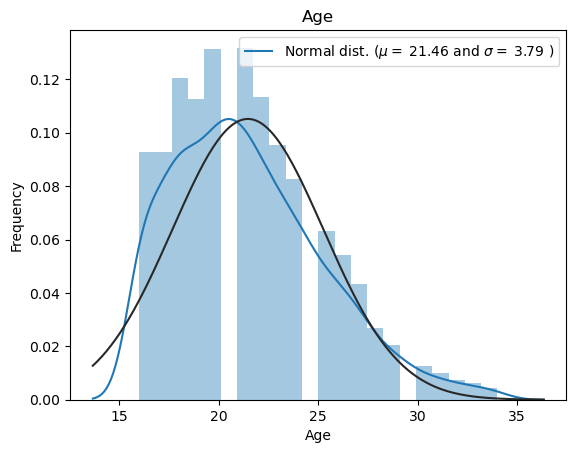

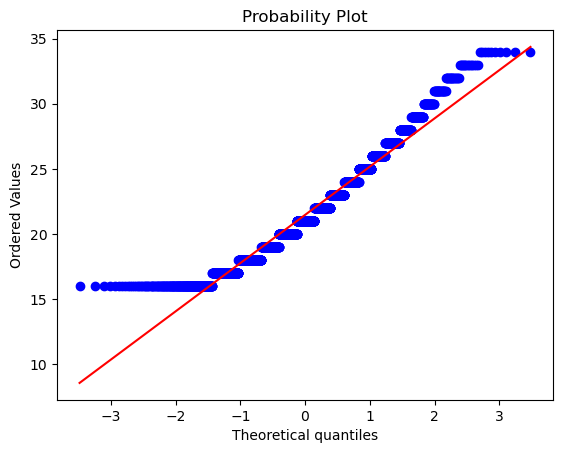


 mu = 14.79 and sigma = 9.55



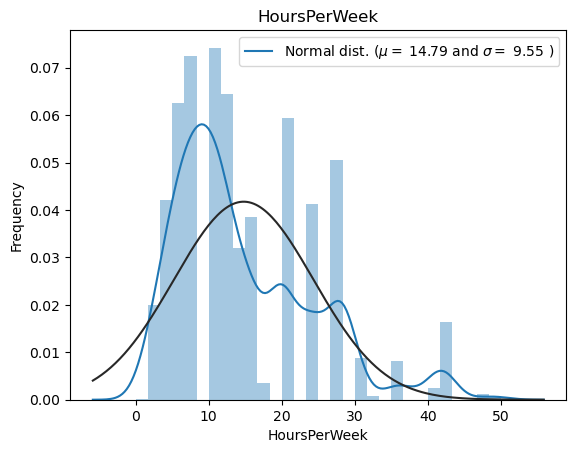

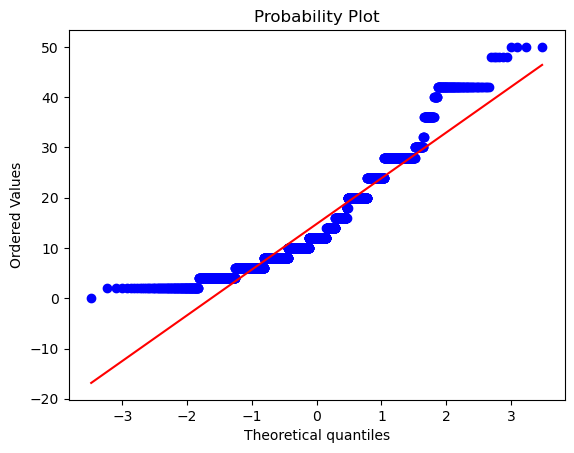


 mu = 623.42 and sigma = 774.05



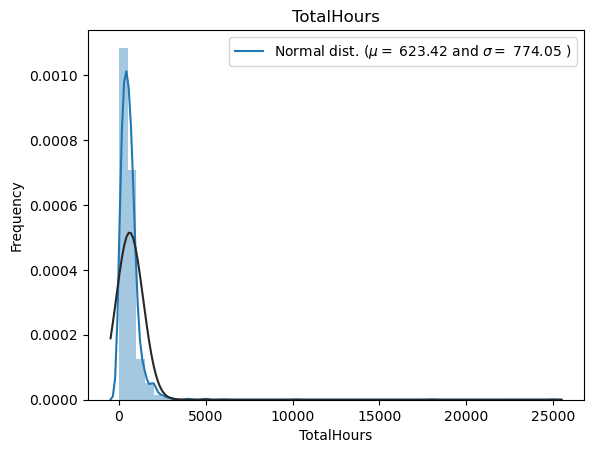

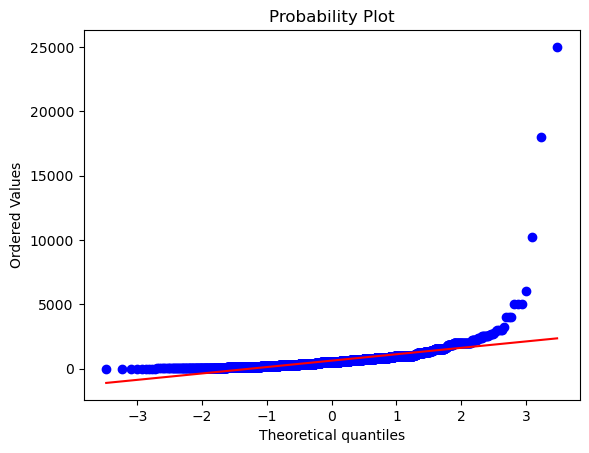


 mu = 109.81 and sigma = 41.59



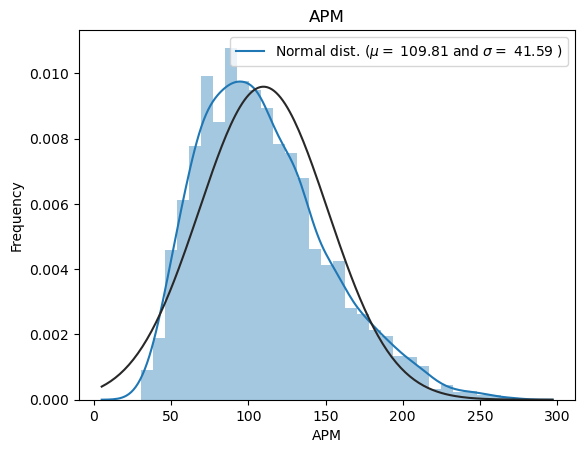

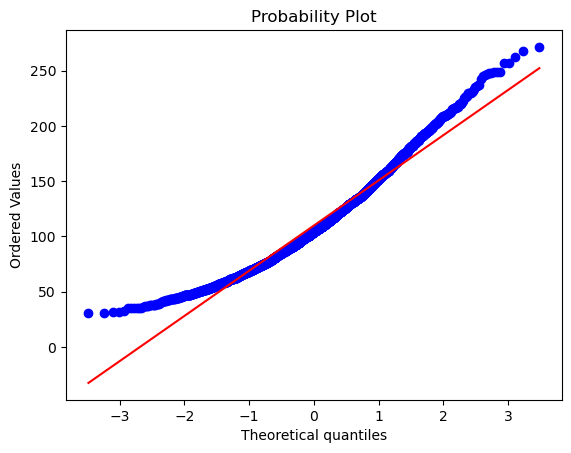


 mu = 0.00 and sigma = 0.00



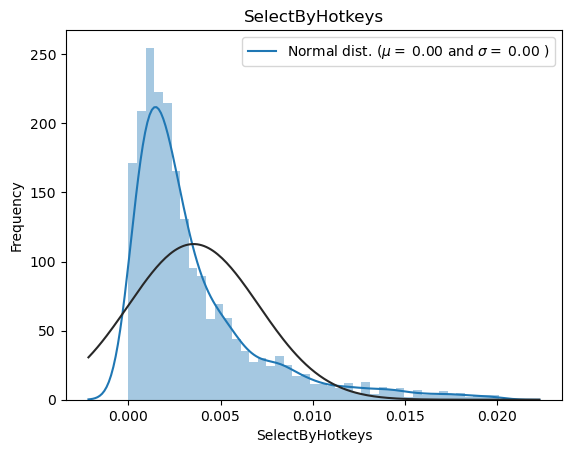

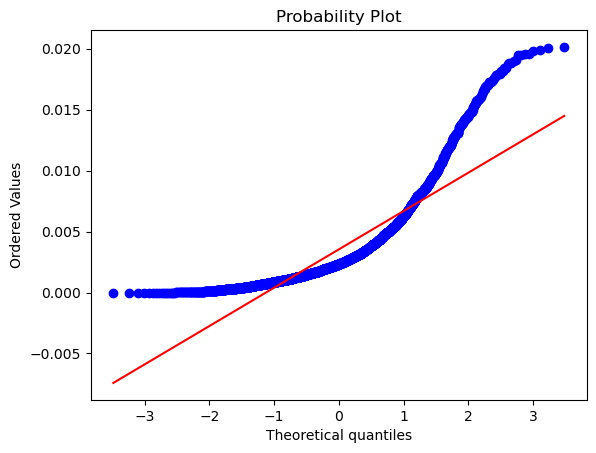


 mu = 0.00 and sigma = 0.00



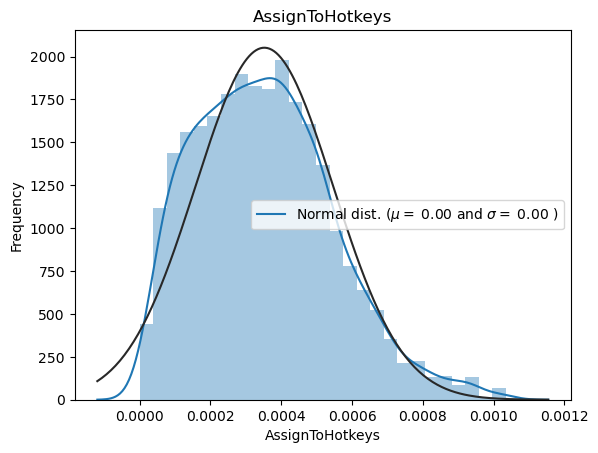

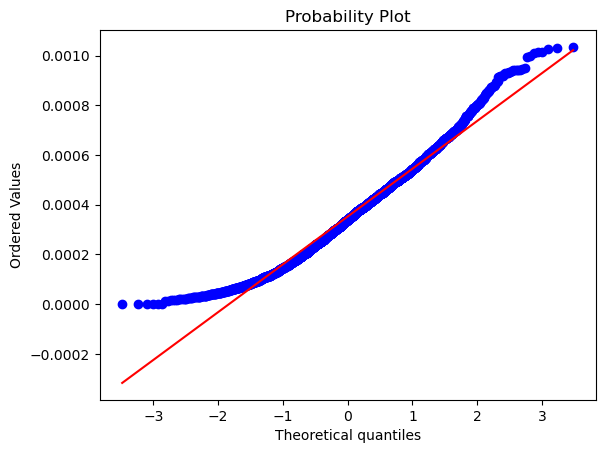


 mu = 4.22 and sigma = 2.30



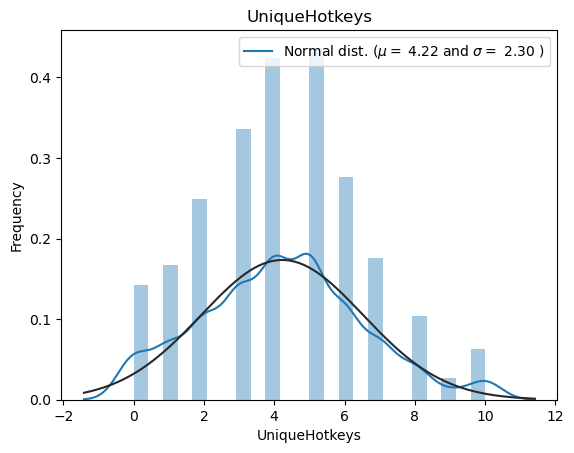

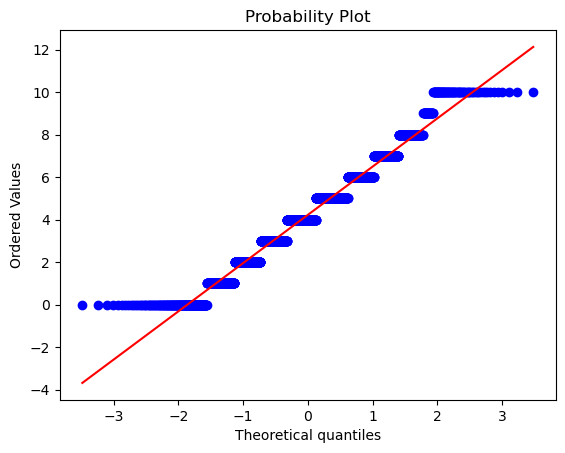


 mu = 0.00 and sigma = 0.00



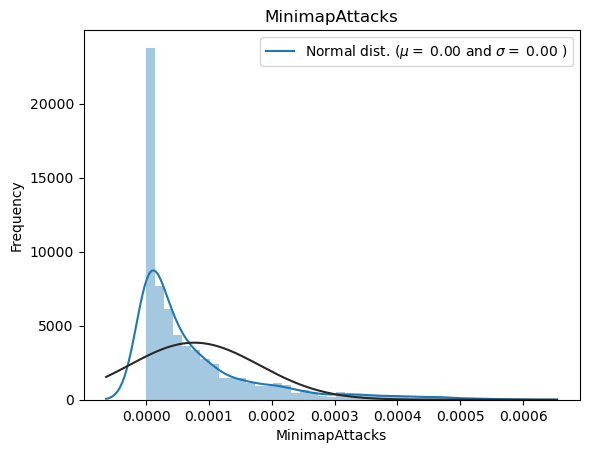

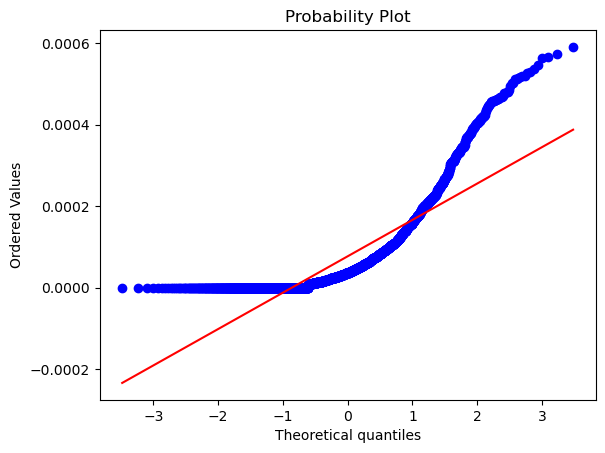


 mu = 0.00 and sigma = 0.00



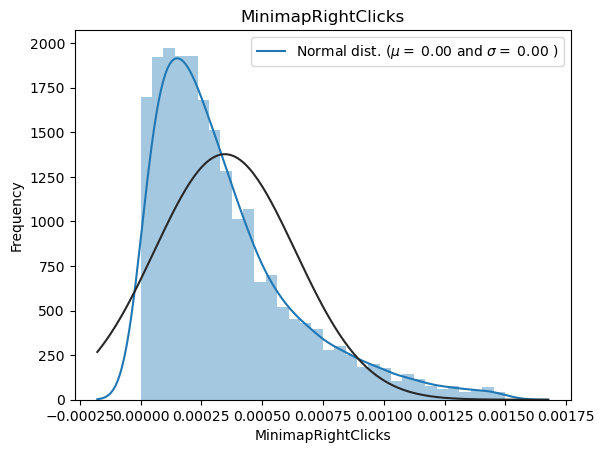

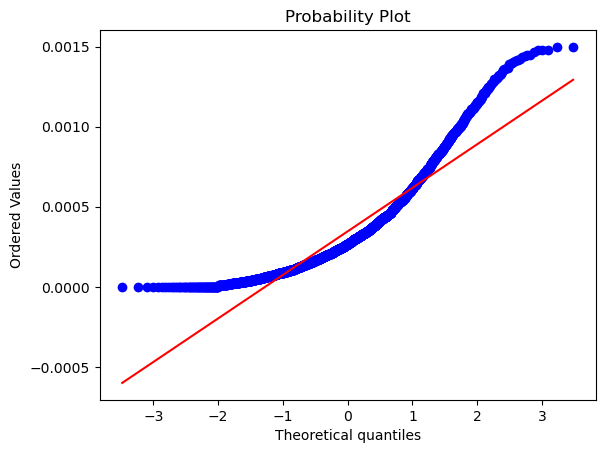


 mu = 0.00 and sigma = 0.00



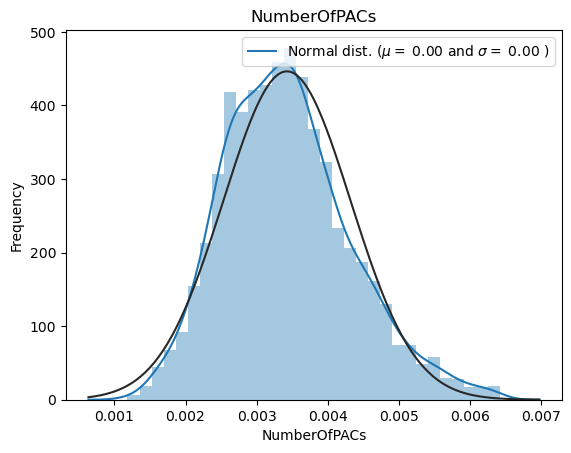

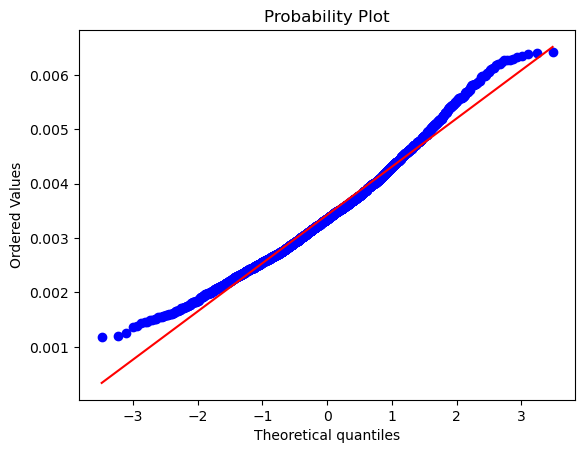


 mu = 40.24 and sigma = 14.35



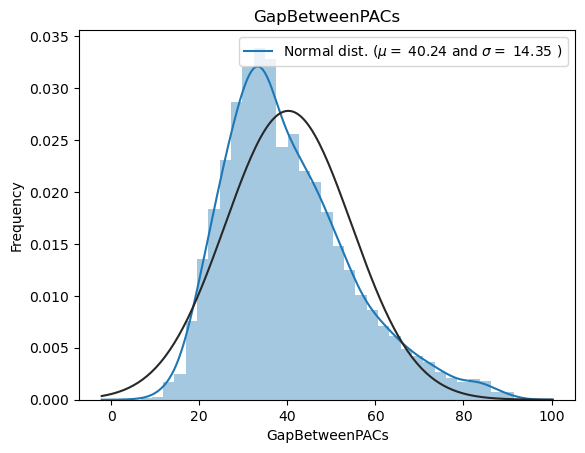

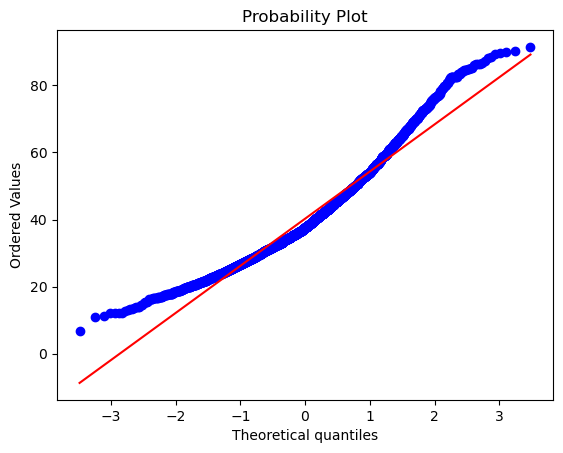


 mu = 63.89 and sigma = 16.56



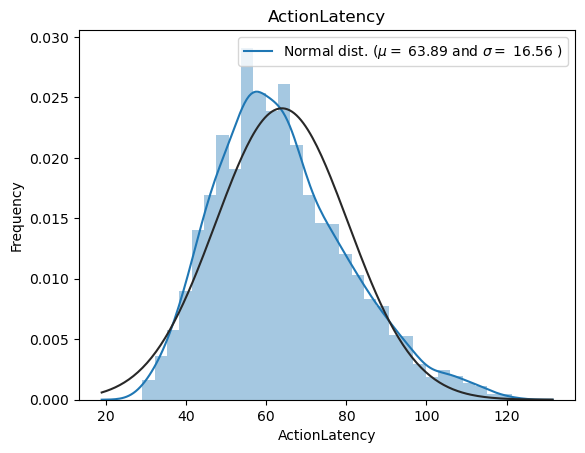

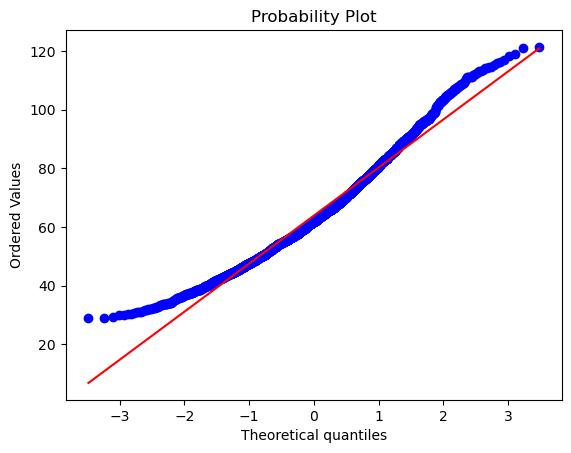


 mu = 5.12 and sigma = 1.27



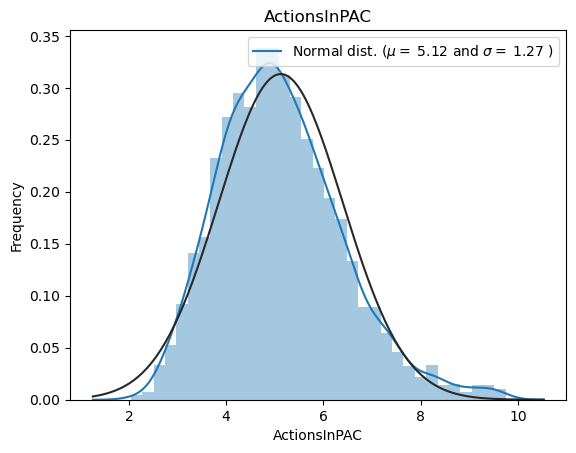

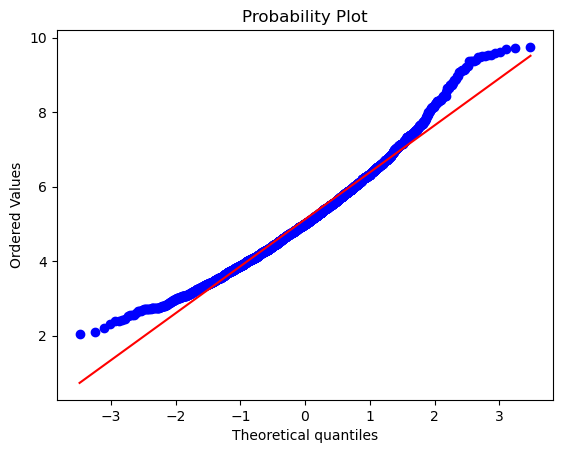


 mu = 21.69 and sigma = 6.85



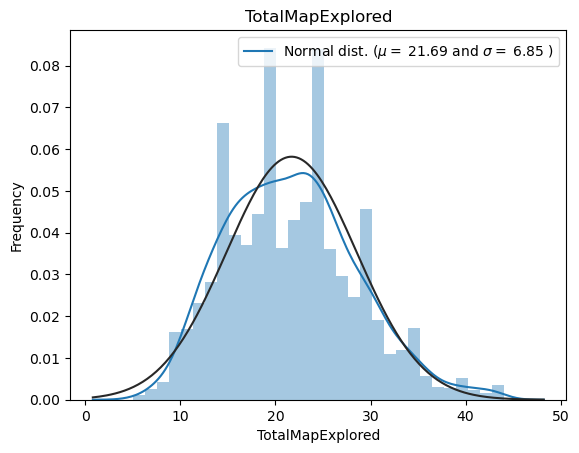

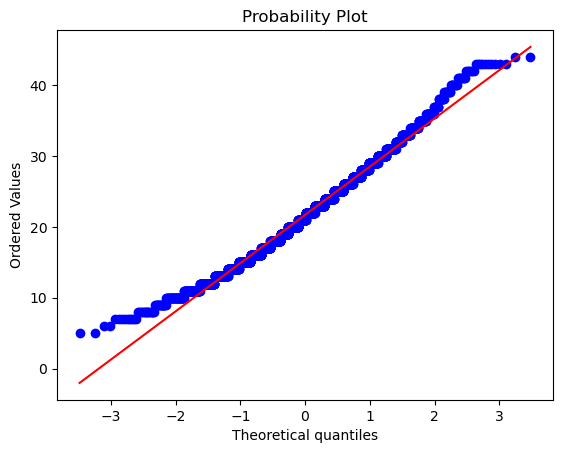


 mu = 0.00 and sigma = 0.00



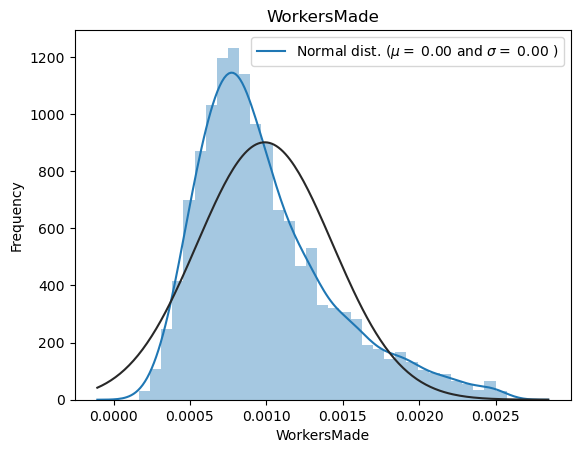

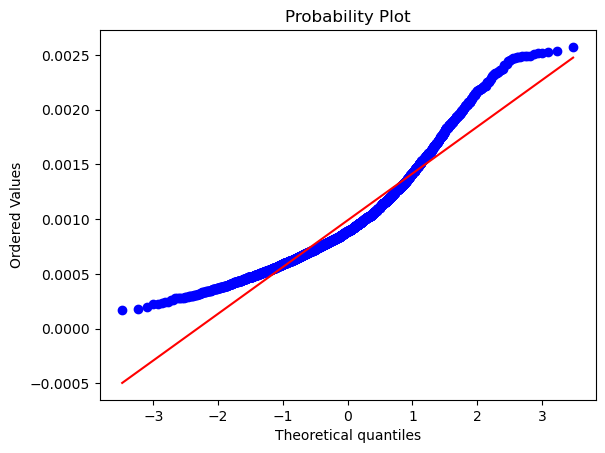


 mu = 6.49 and sigma = 1.81



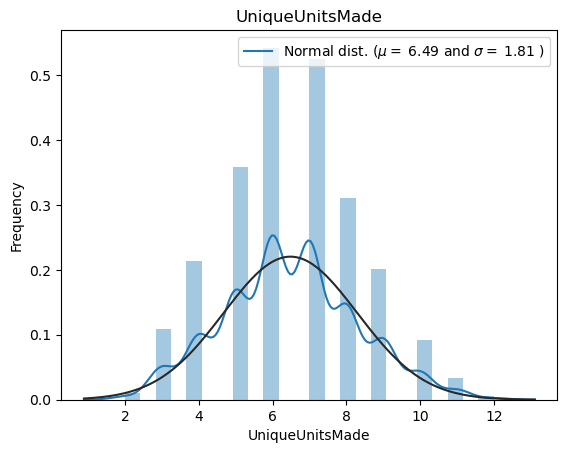

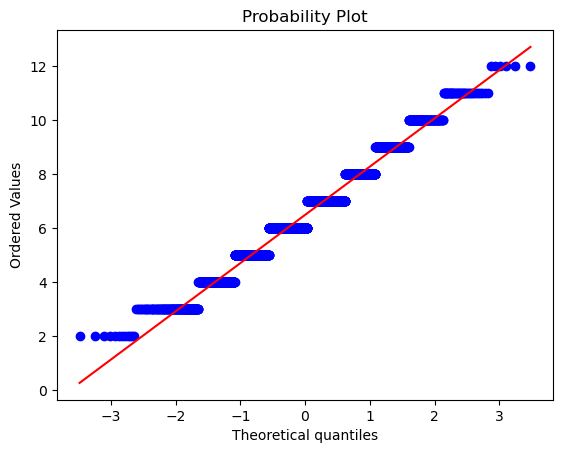


 mu = 0.00 and sigma = 0.00



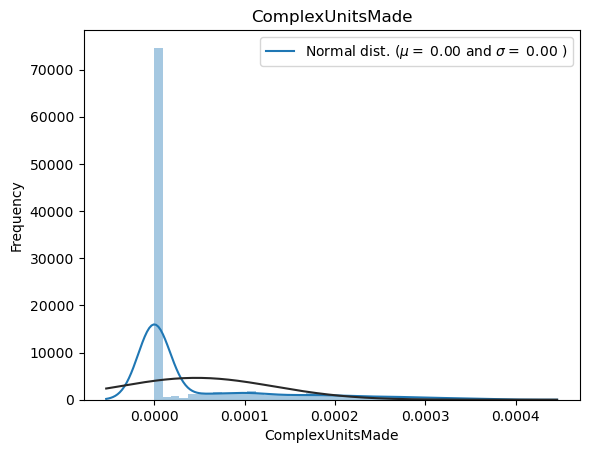

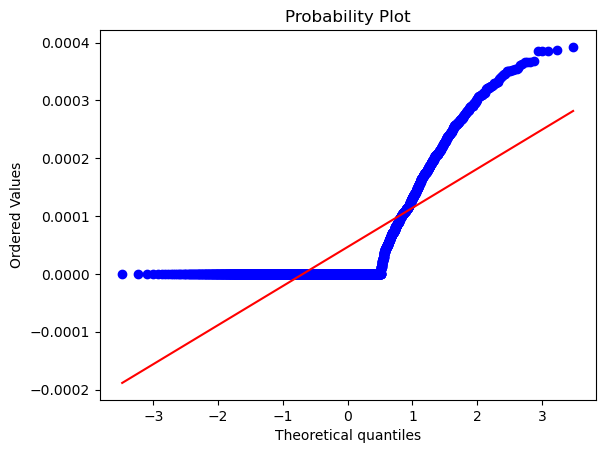


 mu = 0.00 and sigma = 0.00



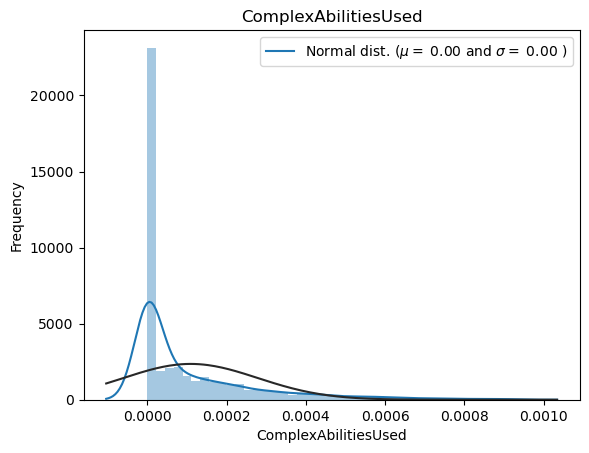

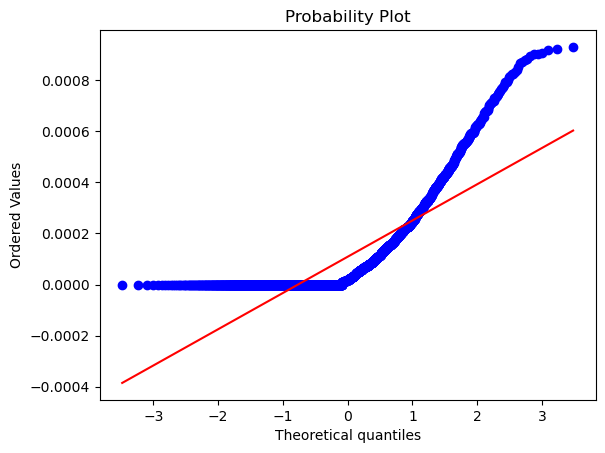

In [32]:
normal_dist_qqplot(starcraft_df,checklist)

Based on this the skewness of 0.75 is selected (https://www.kaggle.com/questions-and-answers/27334)

In [33]:
skewness[abs(skewness) > 0.75]

Skew
TotalHours            16.691910
ComplexAbilitiesUsed   2.040503
MinimapAttacks         2.026281
SelectByHotkeys        1.975126
ComplexUnitsMade       1.864510
MinimapRightClicks     1.370156
HoursPerWeek           1.059040
WorkersMade            1.058656
GapBetweenPACs         0.822606
APM                         NaN
Age                         NaN
ActionsInPAC                NaN
ActionLatency               NaN
AssignToHotkeys             NaN
NumberOfPACs                NaN
TotalMapExplored            NaN
UniqueHotkeys               NaN
UniqueUnitsMade             NaN

In [34]:
skewness = skewness[abs(skewness) > 0.75]
print("There are "+str(skewness.shape[0])+" skewed numerical features to Log-Log transform")
skewed_features = skewness.index
for feat in skewed_features:
    starcraft_df[feat] = np.log1p(starcraft_df[feat])


There are 18 skewed numerical features to Log-Log transform



 mu = 3.10 and sigma = 0.16



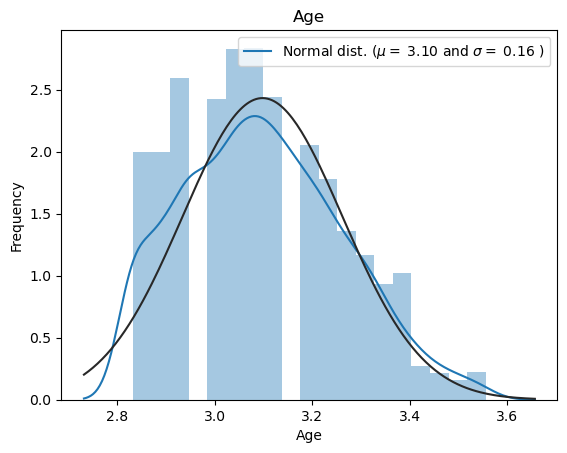

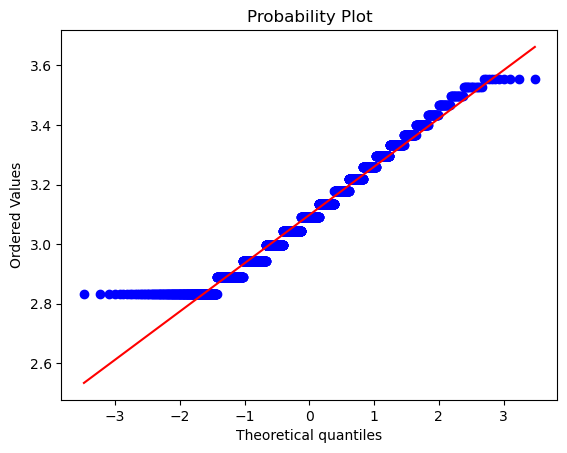


 mu = 2.58 and sigma = 0.62



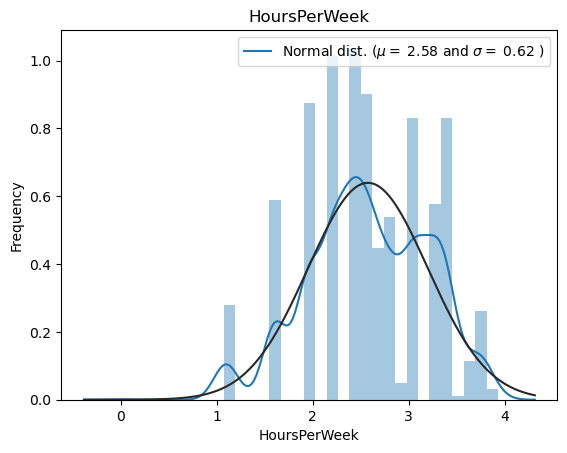

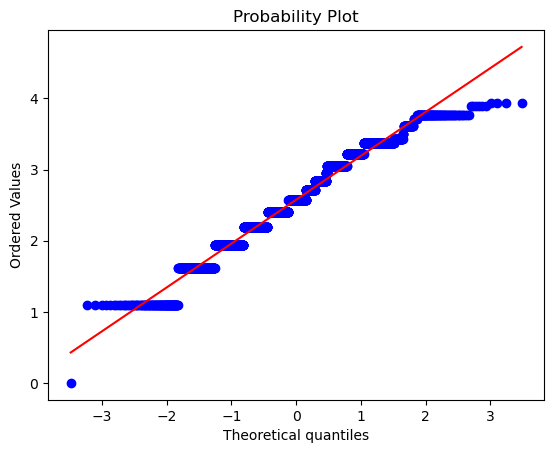


 mu = 6.09 and sigma = 0.90



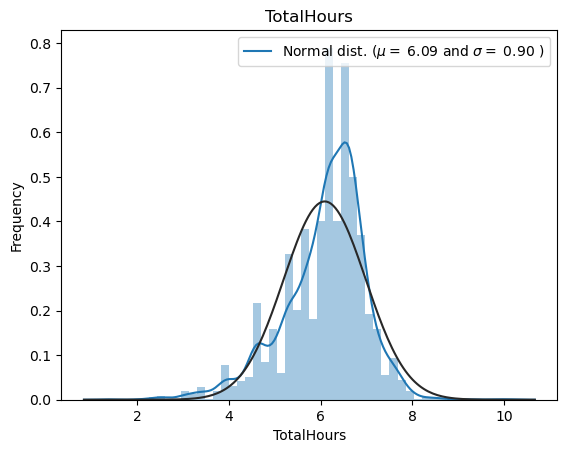

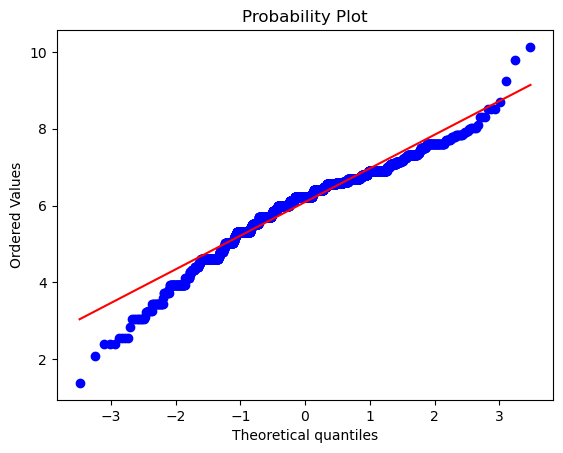


 mu = 4.64 and sigma = 0.38



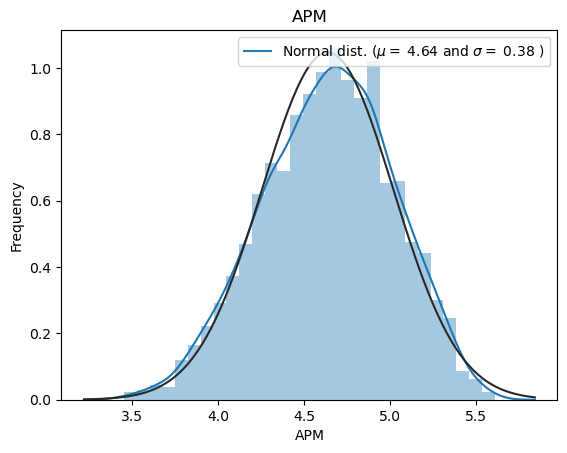

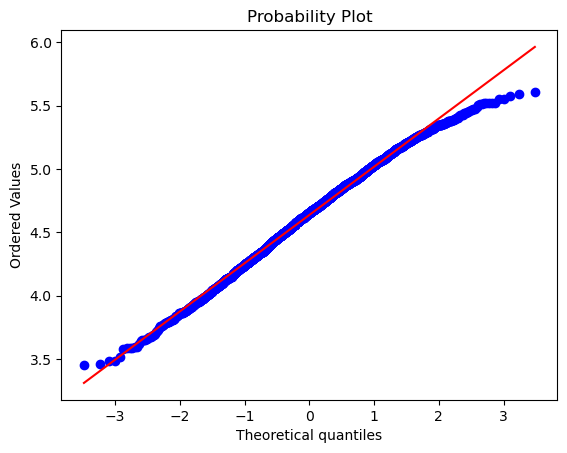


 mu = 0.00 and sigma = 0.00



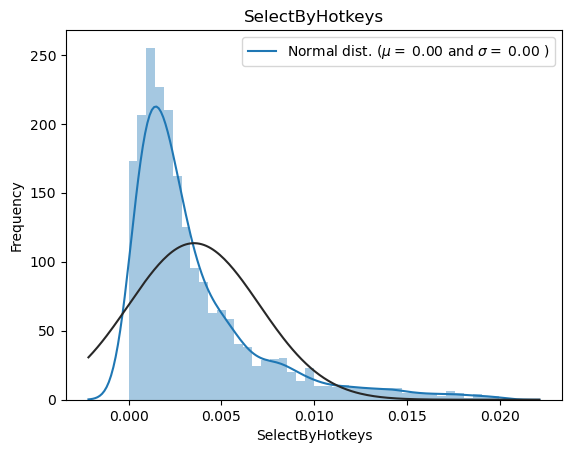

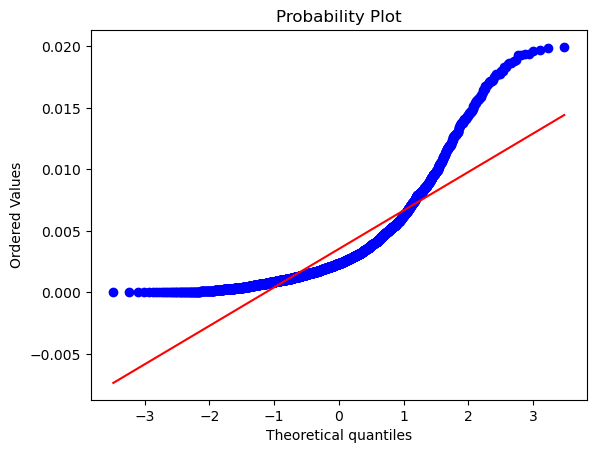


 mu = 0.00 and sigma = 0.00



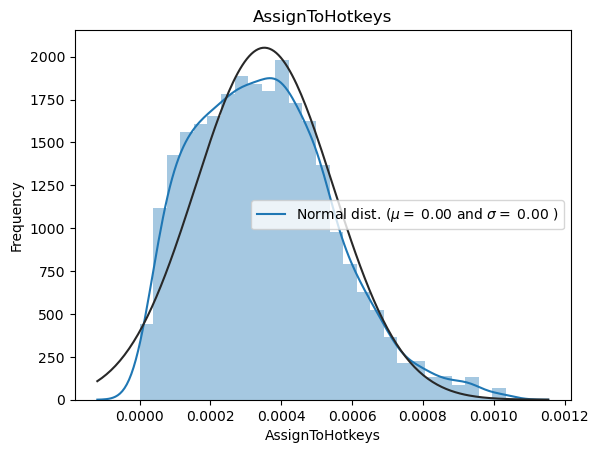

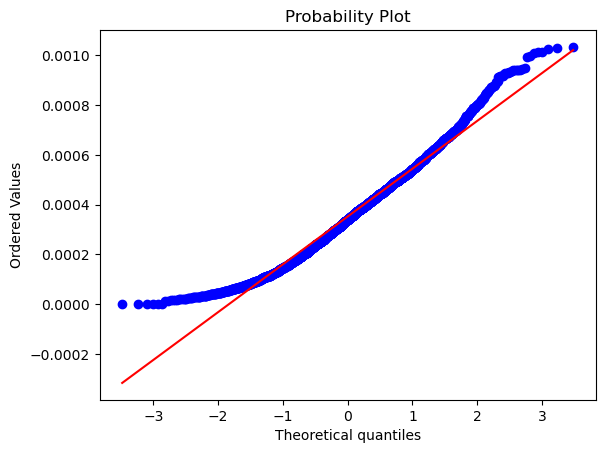


 mu = 1.53 and sigma = 0.56



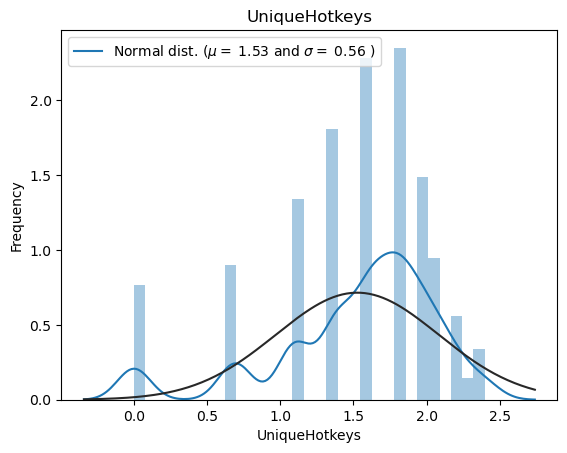

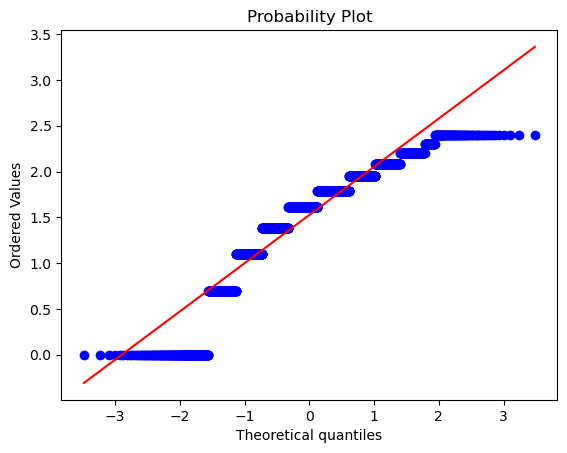


 mu = 0.00 and sigma = 0.00



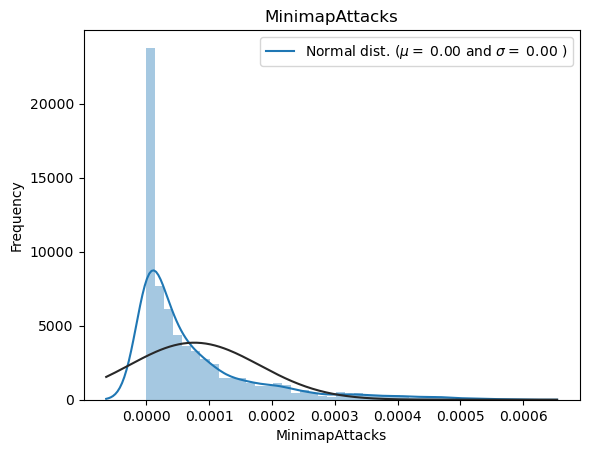

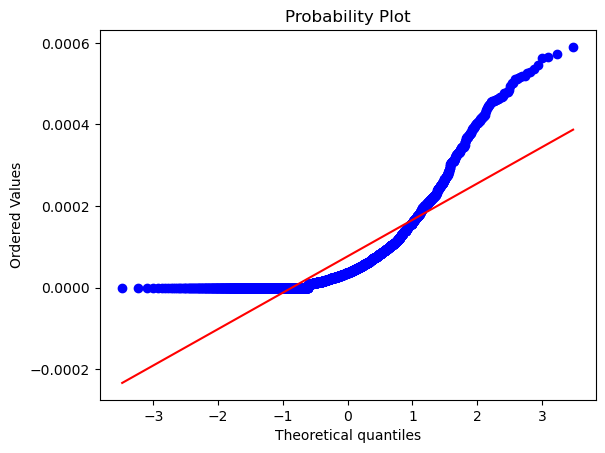


 mu = 0.00 and sigma = 0.00



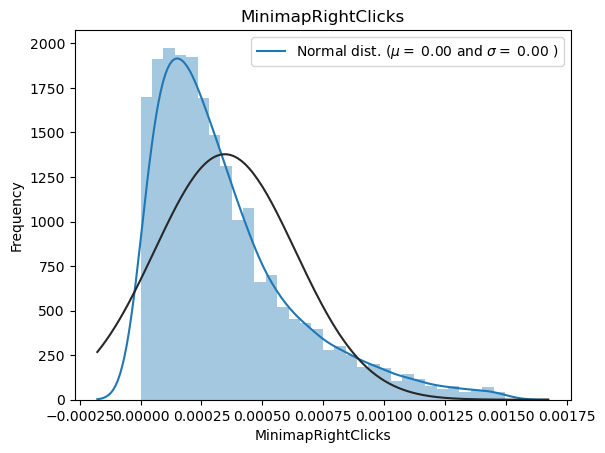

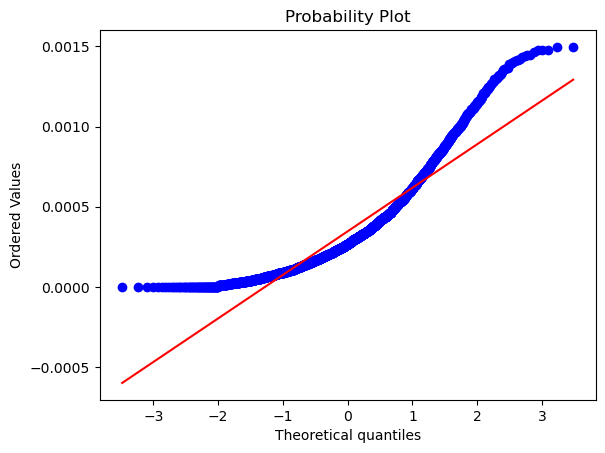


 mu = 0.00 and sigma = 0.00



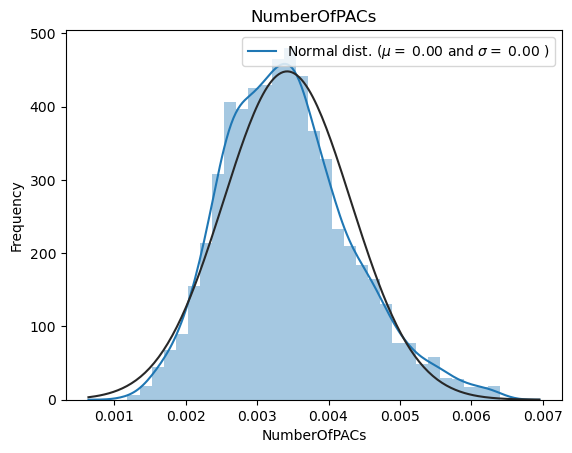

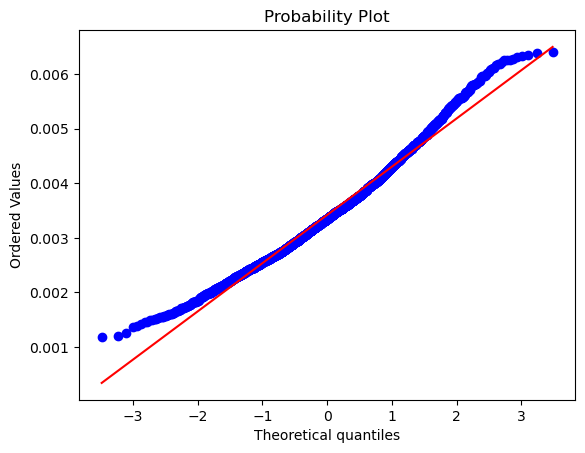


 mu = 3.66 and sigma = 0.35



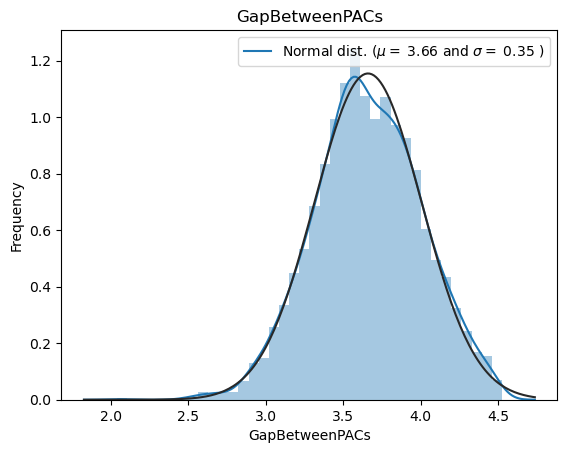

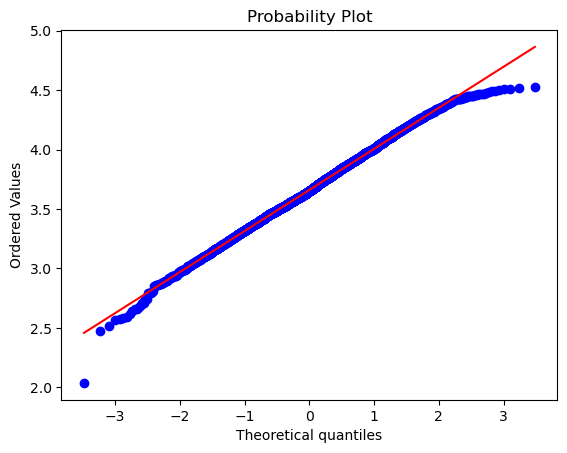


 mu = 4.14 and sigma = 0.25



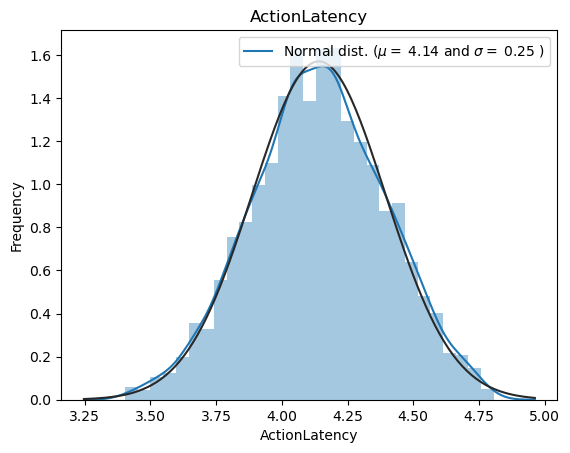

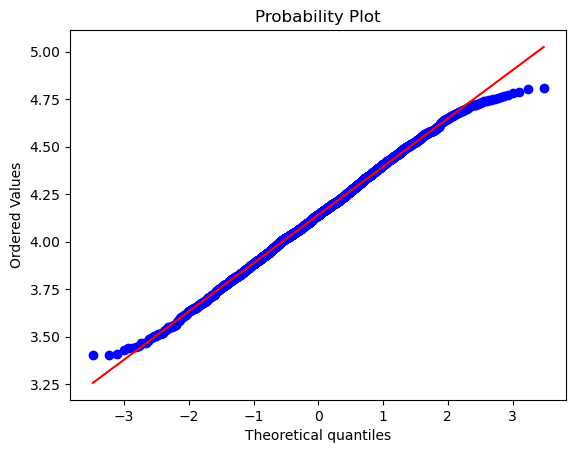


 mu = 1.79 and sigma = 0.21



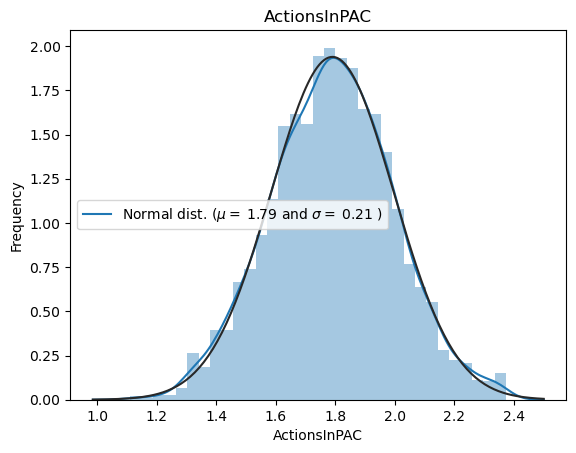

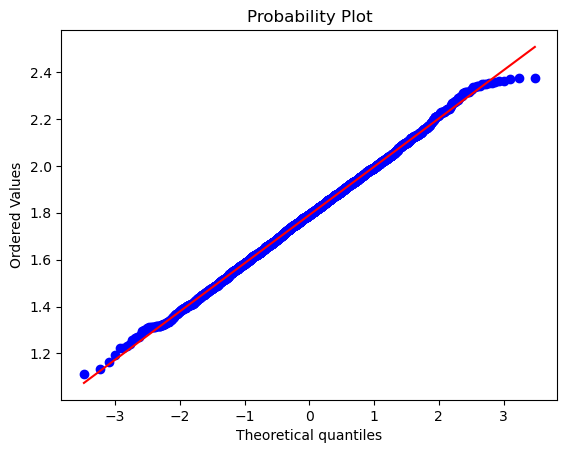


 mu = 3.07 and sigma = 0.32



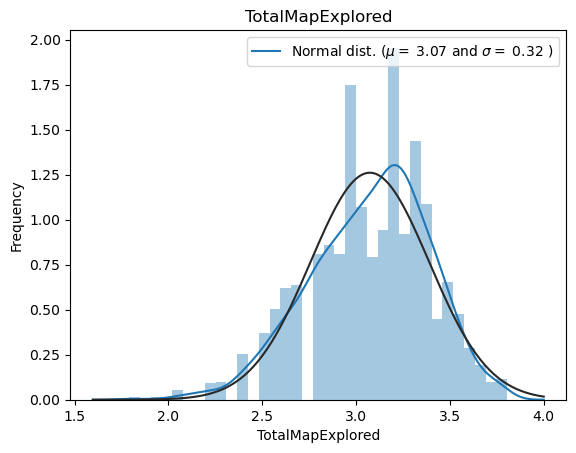

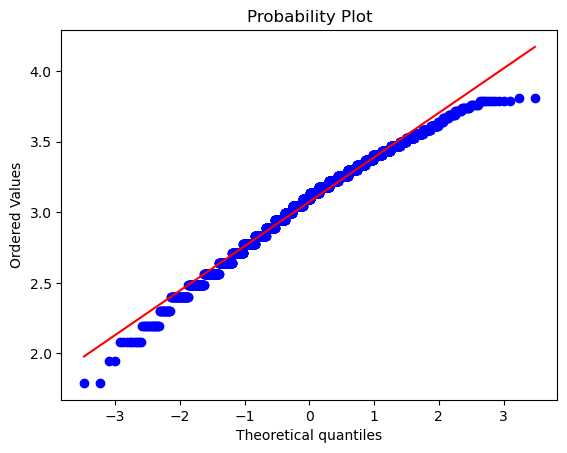


 mu = 0.00 and sigma = 0.00



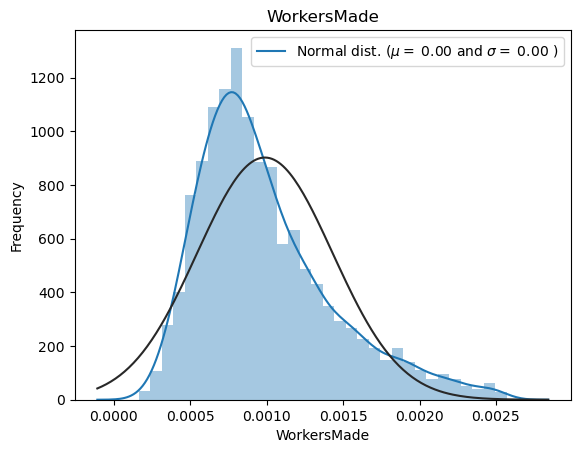

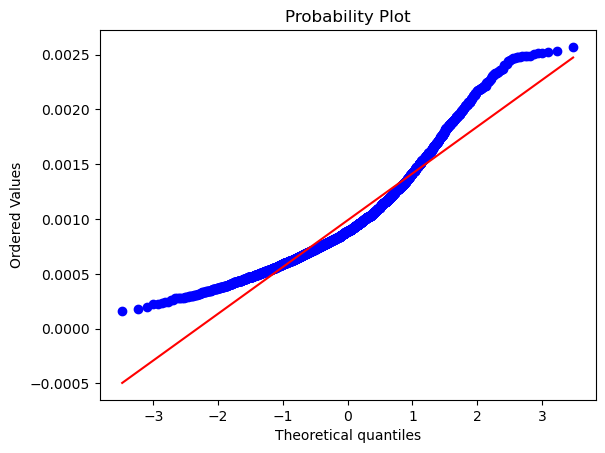


 mu = 1.98 and sigma = 0.26



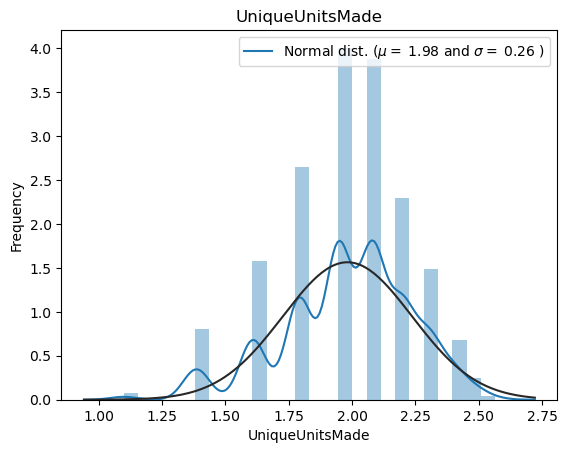

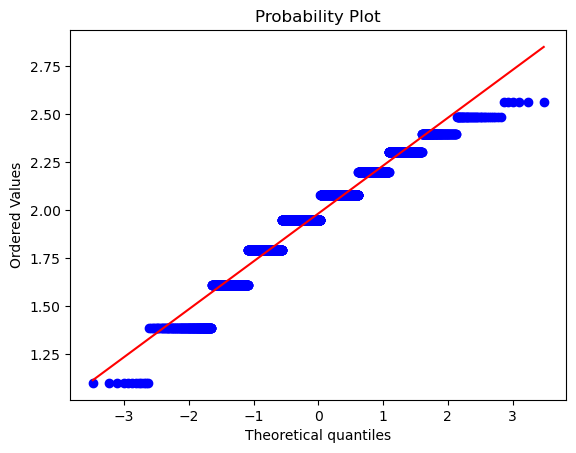


 mu = 0.00 and sigma = 0.00



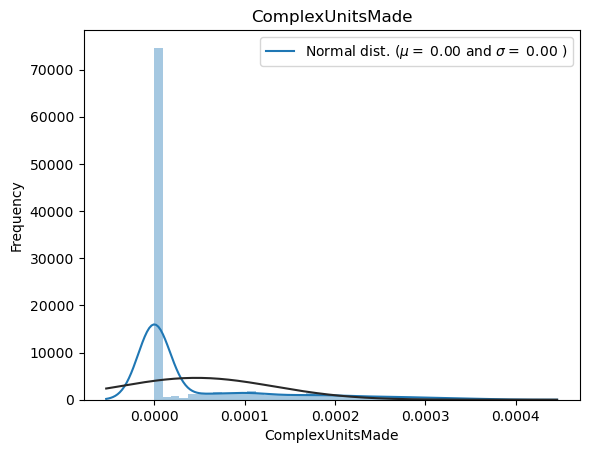

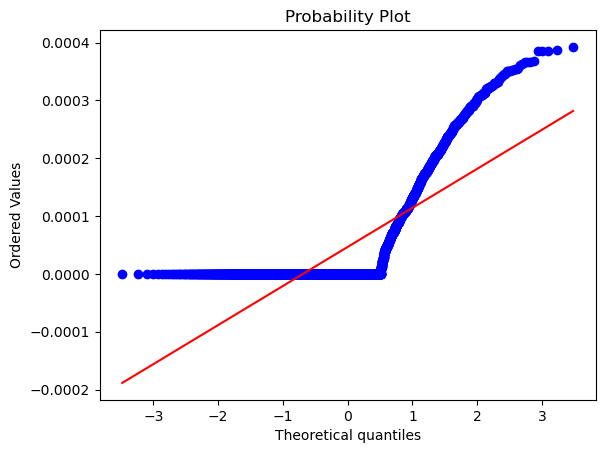


 mu = 0.00 and sigma = 0.00



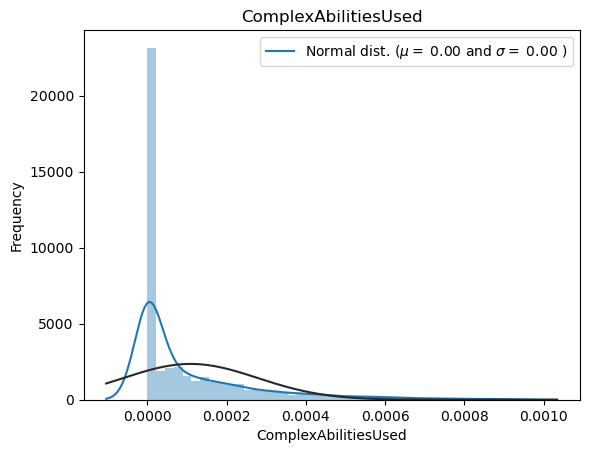

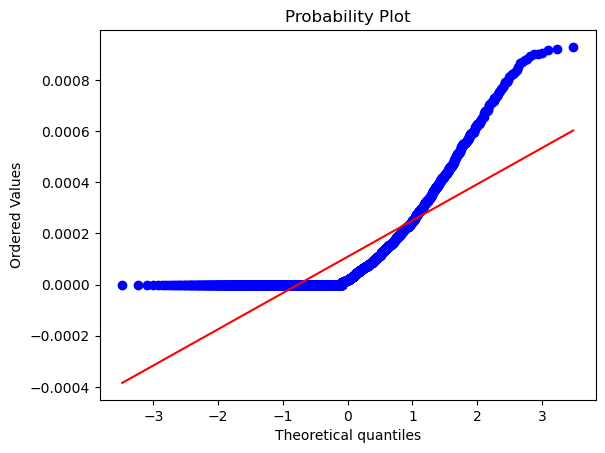

In [35]:
normal_dist_qqplot(starcraft_df,checklist)

"TotalHours, ComplexAbilitiesUsed, MinimapAttacks, SelectByHotkeys, ComplexUnitsMade, MinimapRightClicks, HoursPerWeek, WorkersMade, GapBetweenPACs" columns have been log-log transformed.

#### Correlation check

In [36]:
corr = starcraft_df.corr()
fig = px.imshow(corr, text_auto=True, aspect="auto")
fig.update_layout(width=1600,height=800)
fig.show()

From the above plot we can see that there is no correlations between variables.

## Machine Learning

## Multi Class Classification 

The metric we'll be looking at would be f1-weighted. It tends to give better results for multiclass classification problem.

In [37]:
RANDOM_SEED=42

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import roc_curve,auc,classification_report

from sklearn.calibration import CalibratedClassifierCV


In [39]:
X=starcraft_df.drop(["LeagueIndex"], axis = 1)
y=starcraft_df.LeagueIndex

In [40]:
# split the data set into train and test 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=RANDOM_SEED)

In [41]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [42]:
classifiers = [
    SGDClassifier(max_iter=1000, tol=1e-3, random_state=RANDOM_SEED),
    KNeighborsClassifier(),
    LogisticRegression(solver="lbfgs", random_state=RANDOM_SEED),
    LogisticRegressionCV(cv=3, random_state=RANDOM_SEED),
    BaggingClassifier(random_state=RANDOM_SEED),
    GaussianNB(),
    RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_SEED),
    XGBClassifier(n_estimators=100, random_state=RANDOM_SEED),
    SVC()
]

SGDClassifier
Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.67      0.02      0.04        98
           1       0.39      0.29      0.33       240
           2       0.33      0.10      0.15       389
           3       0.00      0.00      0.00       577
           4       0.28      0.97      0.44       538
           5       0.72      0.15      0.25       365
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7

    accuracy                           0.31      2224
   macro avg       0.30      0.19      0.15      2224
weighted avg       0.32      0.31      0.21      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.35      0.23      0.28        60
           2       0.35      0.13      0.19        97
           3       0.00      0.00      0.00       144
           4       0.28      0.96  

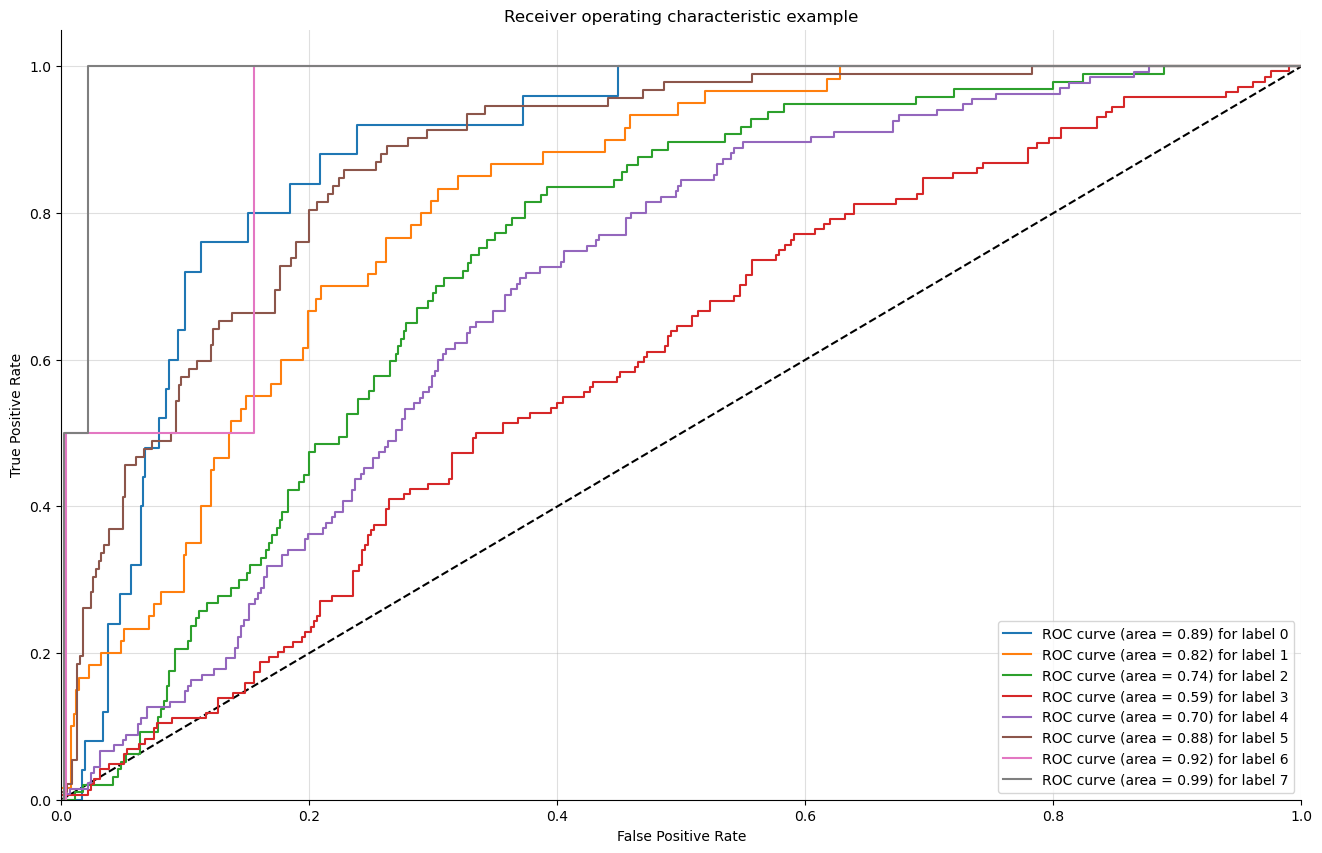

KNeighborsClassifier
Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.52      0.44      0.48        98
           1       0.47      0.53      0.50       240
           2       0.51      0.54      0.53       389
           3       0.52      0.57      0.55       577
           4       0.56      0.55      0.56       538
           5       0.66      0.55      0.60       365
           6       0.00      0.00      0.00        10
           7       1.00      0.43      0.60         7

    accuracy                           0.54      2224
   macro avg       0.53      0.45      0.47      2224
weighted avg       0.55      0.54      0.54      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.12      0.12      0.12        25
           1       0.17      0.20      0.19        60
           2       0.30      0.33      0.31        97
           3       0.34      0.35      0.35       144
           4       0.33     

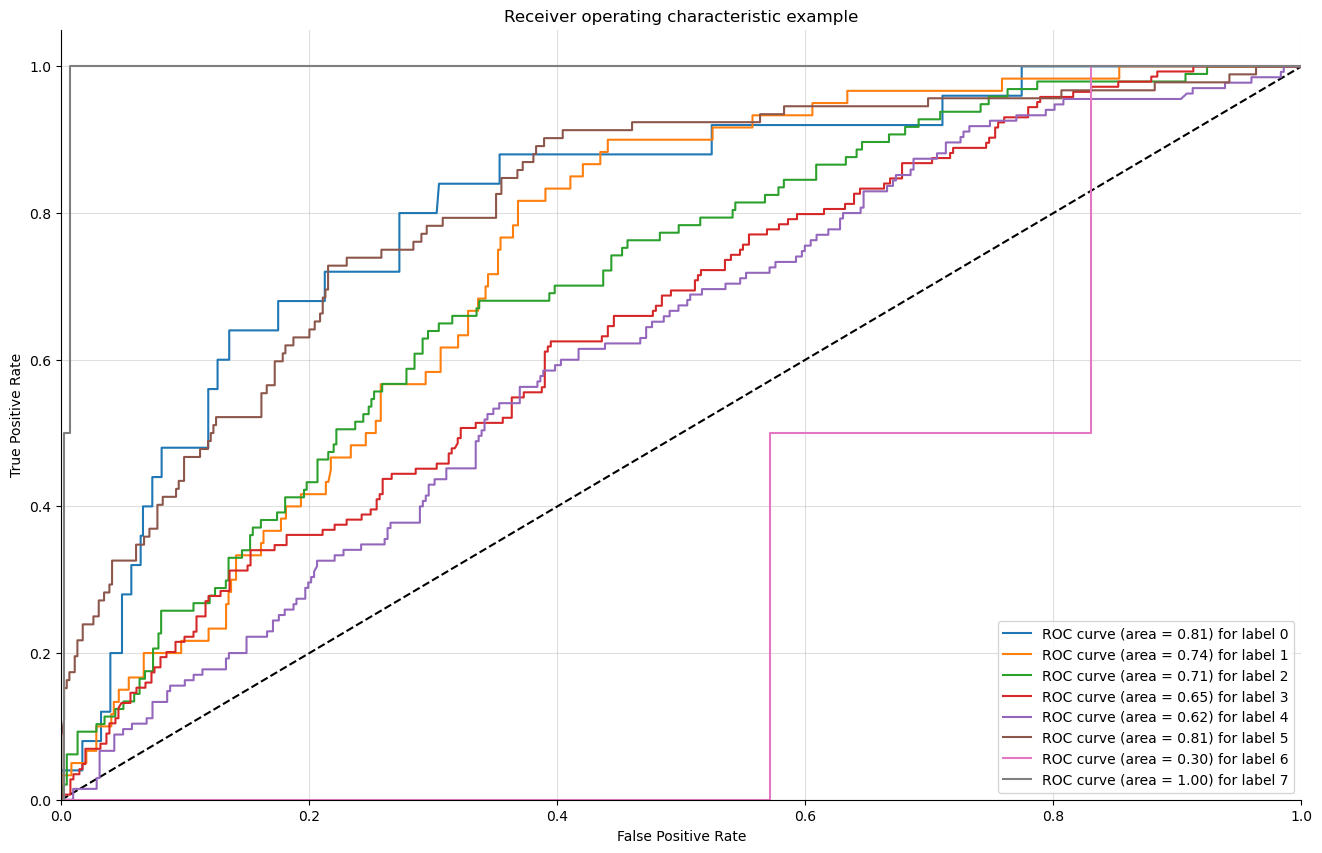

LogisticRegression
Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.51      0.31      0.38        98
           1       0.41      0.30      0.35       240
           2       0.37      0.21      0.26       389
           3       0.36      0.56      0.44       577
           4       0.42      0.43      0.43       538
           5       0.55      0.50      0.53       365
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7

    accuracy                           0.41      2224
   macro avg       0.33      0.29      0.30      2224
weighted avg       0.42      0.41      0.40      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.09      0.04      0.06        25
           1       0.26      0.20      0.22        60
           2       0.31      0.19      0.23        97
           3       0.42      0.63      0.51       144
           4       0.46      0

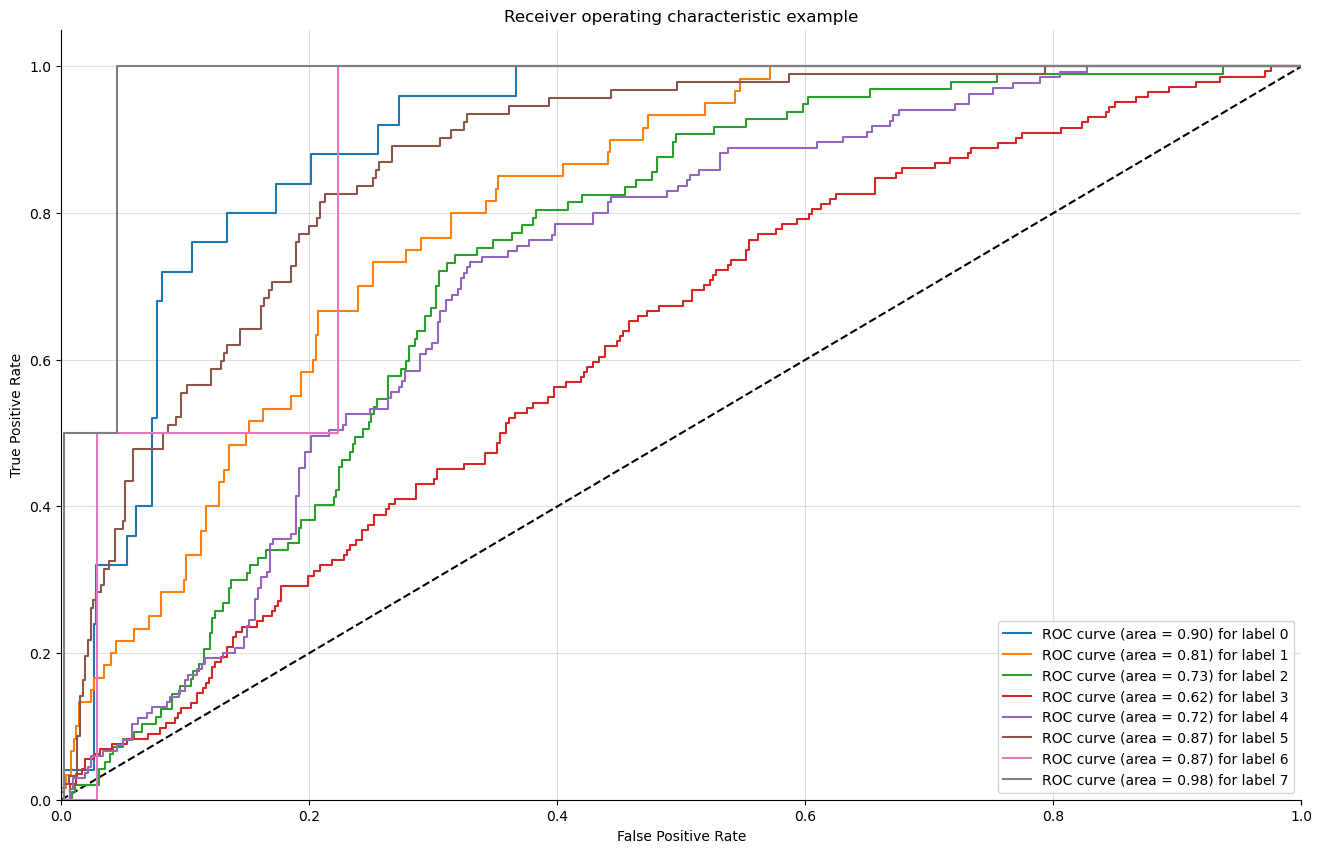

LogisticRegressionCV
Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.62      0.29      0.39        98
           1       0.43      0.37      0.39       240
           2       0.39      0.23      0.29       389
           3       0.37      0.54      0.44       577
           4       0.41      0.43      0.42       538
           5       0.54      0.50      0.52       365
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7

    accuracy                           0.42      2224
   macro avg       0.35      0.29      0.31      2224
weighted avg       0.43      0.42      0.41      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.10      0.04      0.06        25
           1       0.29      0.25      0.27        60
           2       0.37      0.24      0.29        97
           3       0.42      0.58      0.49       144
           4       0.48     

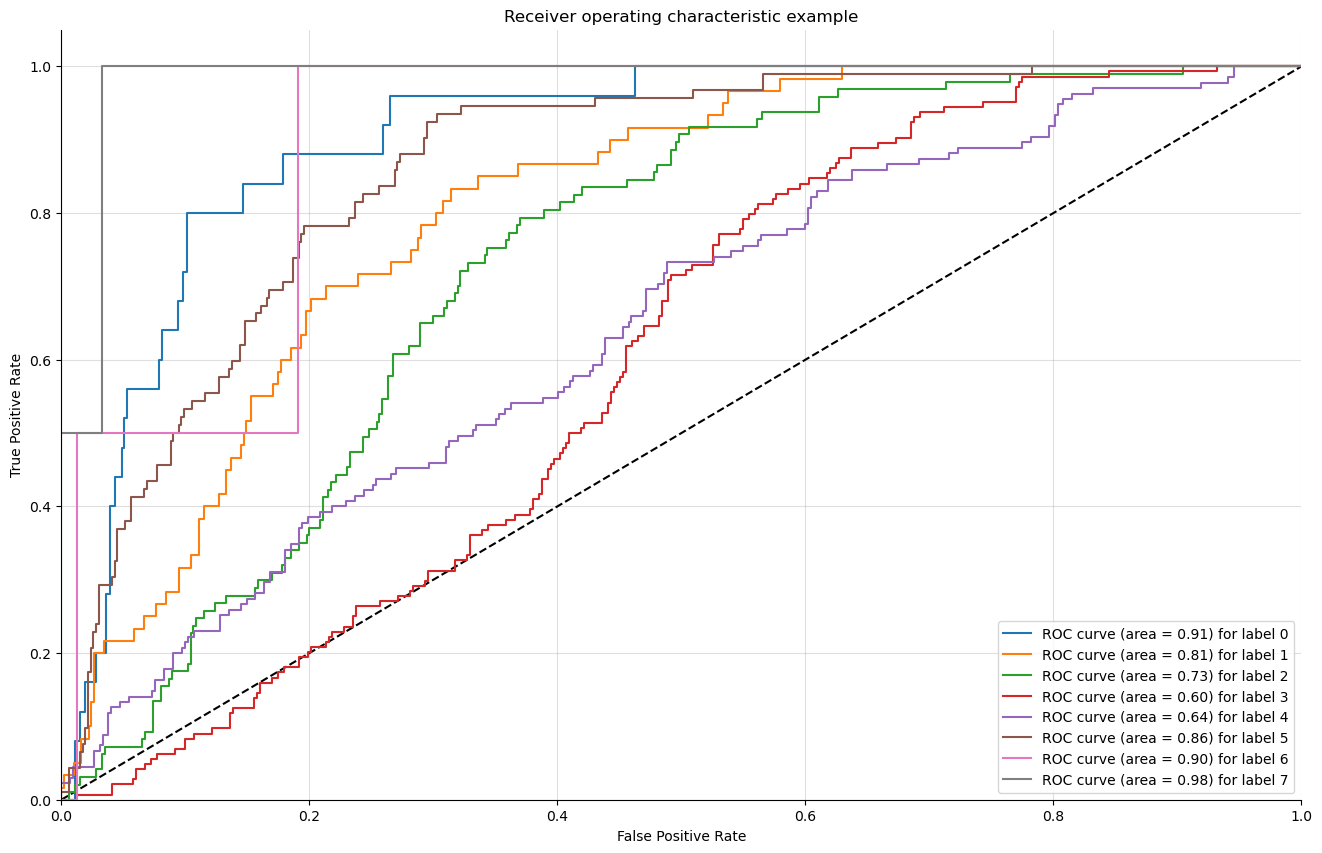

BaggingClassifier
Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        98
           1       1.00      0.98      0.99       240
           2       0.98      0.99      0.99       389
           3       0.98      0.98      0.98       577
           4       0.97      0.98      0.98       538
           5       0.99      0.98      0.99       365
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00         7

    accuracy                           0.98      2224
   macro avg       0.99      0.99      0.99      2224
weighted avg       0.98      0.98      0.98      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.29      0.24      0.26        25
           1       0.26      0.25      0.26        60
           2       0.22      0.25      0.23        97
           3       0.32      0.35      0.34       144
           4       0.40      0.

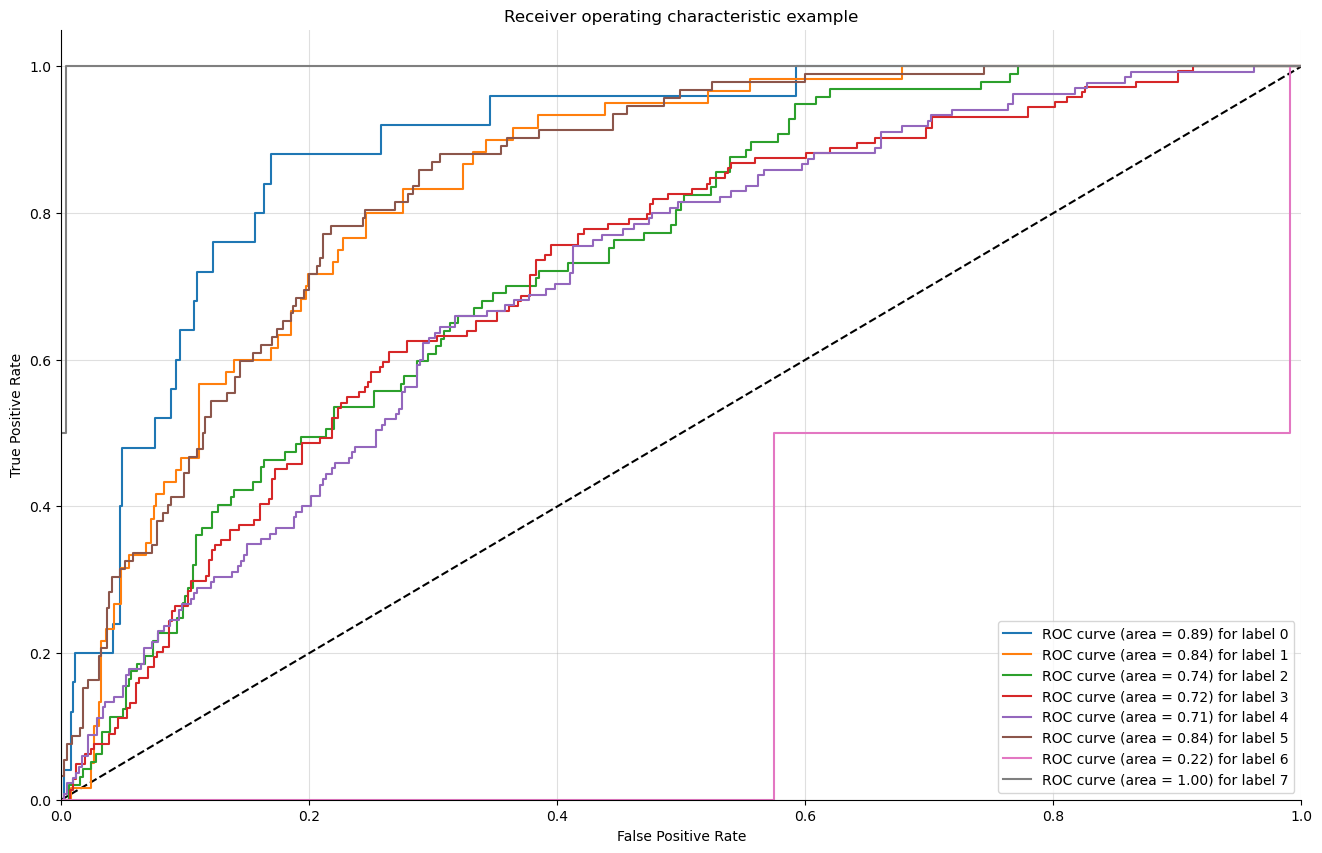

GaussianNB
Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.25      0.59      0.35        98
           1       0.26      0.37      0.30       240
           2       0.33      0.20      0.25       389
           3       0.40      0.33      0.37       577
           4       0.44      0.38      0.41       538
           5       0.50      0.58      0.54       365
           6       0.14      0.50      0.21        10
           7       1.00      1.00      1.00         7

    accuracy                           0.38      2224
   macro avg       0.41      0.49      0.43      2224
weighted avg       0.39      0.38      0.38      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.21      0.44      0.28        25
           1       0.24      0.35      0.28        60
           2       0.26      0.19      0.22        97
           3       0.37      0.30      0.33       144
           4       0.36      0.33     

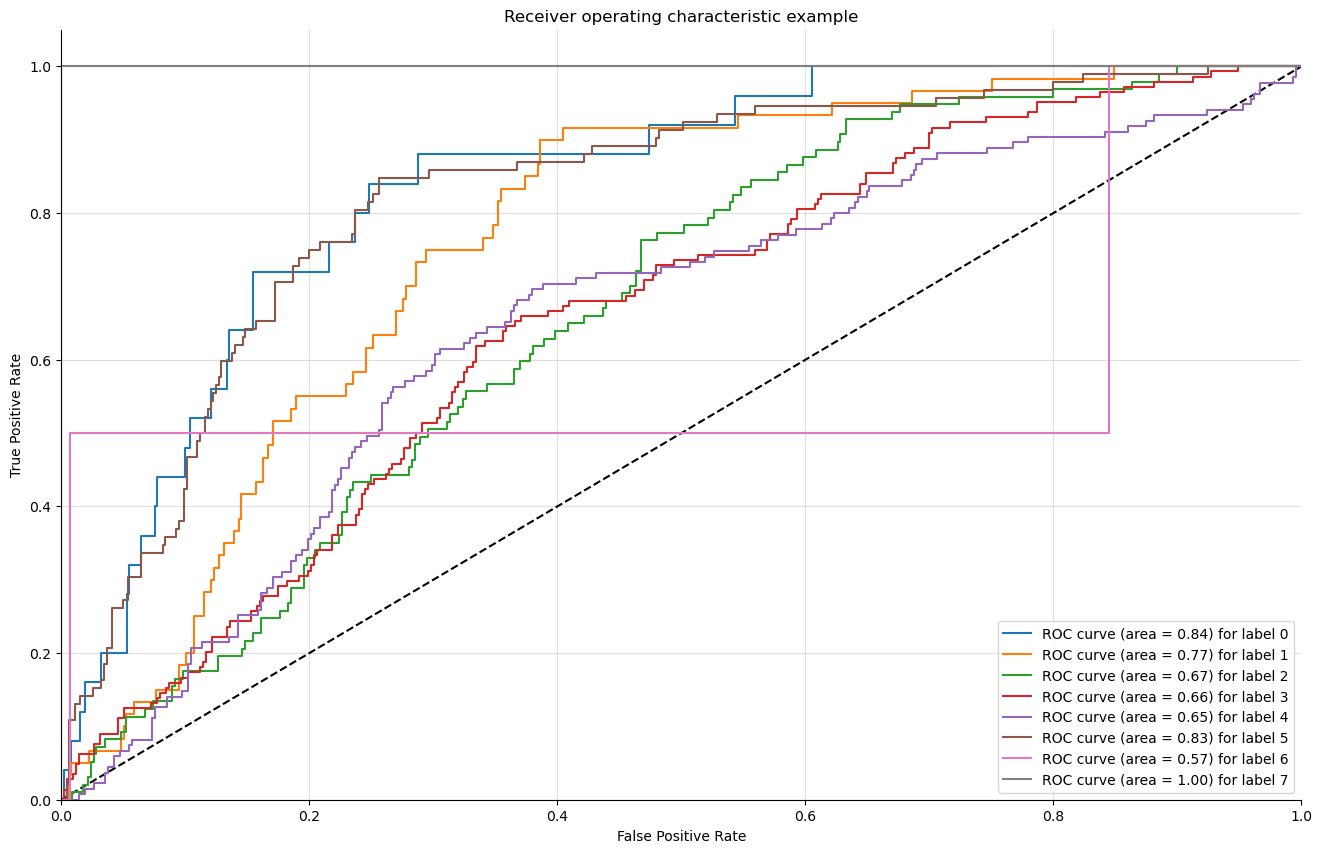

RandomForestClassifier
Y_Train Y_Pred
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       389
           3       1.00      1.00      1.00       577
           4       1.00      1.00      1.00       538
           5       1.00      1.00      1.00       365
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00         7

    accuracy                           1.00      2224
   macro avg       1.00      1.00      1.00      2224
weighted avg       1.00      1.00      1.00      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.20      0.08      0.11        25
           1       0.31      0.30      0.31        60
           2       0.32      0.29      0.30        97
           3       0.45      0.53      0.49       144
           4       0.44   

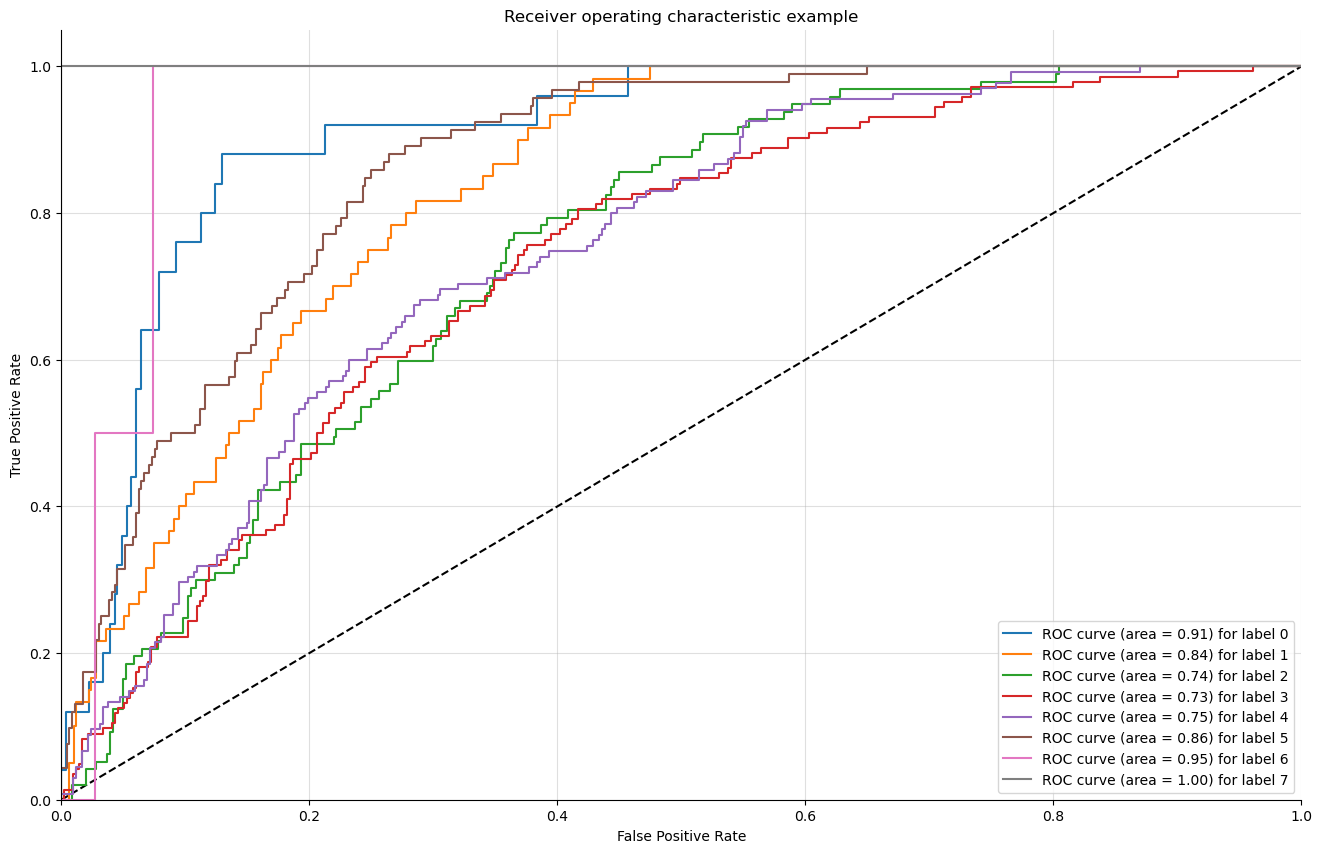

ExtraTreesClassifier
Y_Train Y_Pred
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       389
           3       1.00      1.00      1.00       577
           4       1.00      1.00      1.00       538
           5       1.00      1.00      1.00       365
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00         7

    accuracy                           1.00      2224
   macro avg       1.00      1.00      1.00      2224
weighted avg       1.00      1.00      1.00      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.20      0.08      0.11        25
           1       0.32      0.27      0.29        60
           2       0.37      0.36      0.37        97
           3       0.43      0.53      0.48       144
           4       0.48     

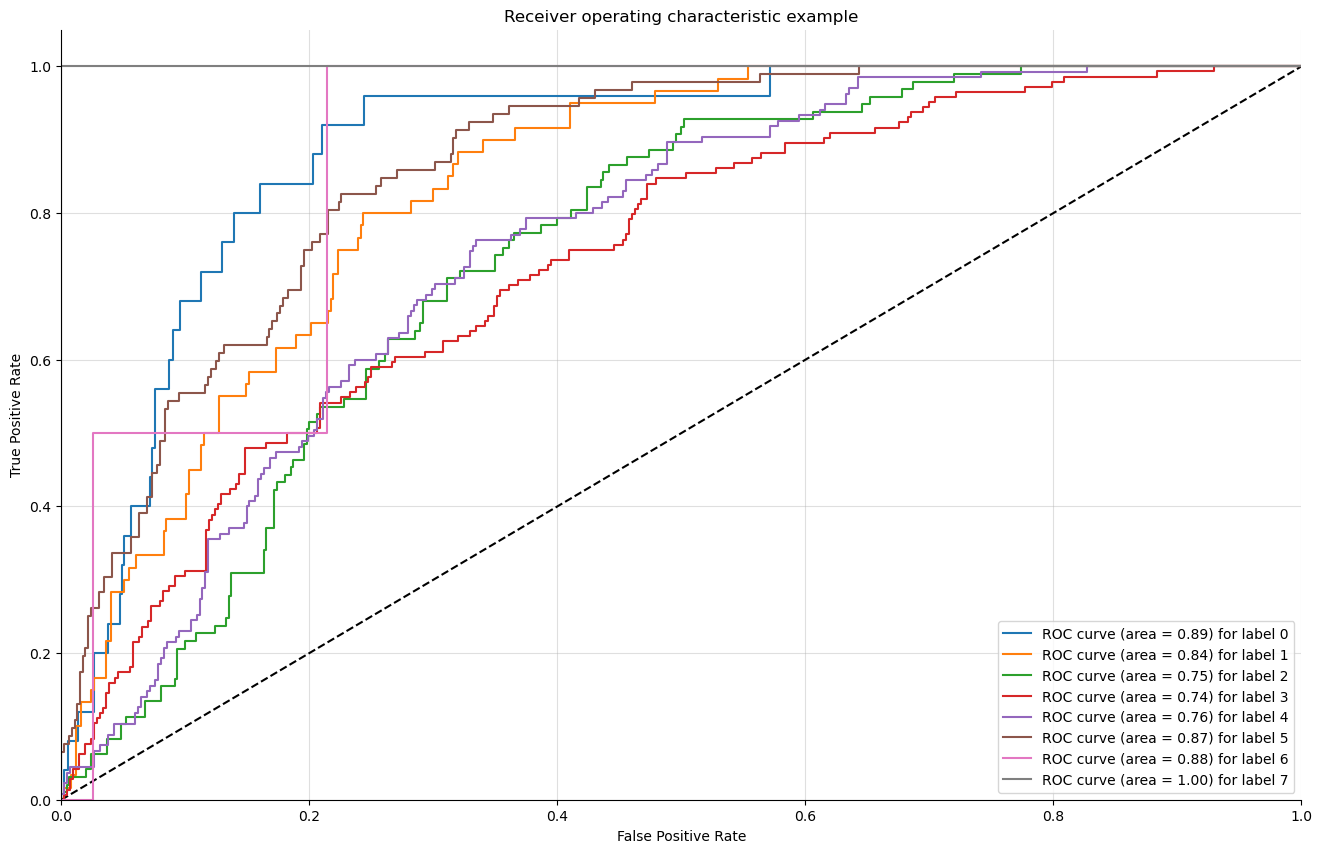

XGBClassifier
Y_Train Y_Pred
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       389
           3       1.00      1.00      1.00       577
           4       1.00      1.00      1.00       538
           5       1.00      1.00      1.00       365
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00         7

    accuracy                           1.00      2224
   macro avg       1.00      1.00      1.00      2224
weighted avg       1.00      1.00      1.00      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.08      0.04      0.05        25
           1       0.40      0.33      0.36        60
           2       0.24      0.25      0.25        97
           3       0.42      0.50      0.46       144
           4       0.43      0.44  

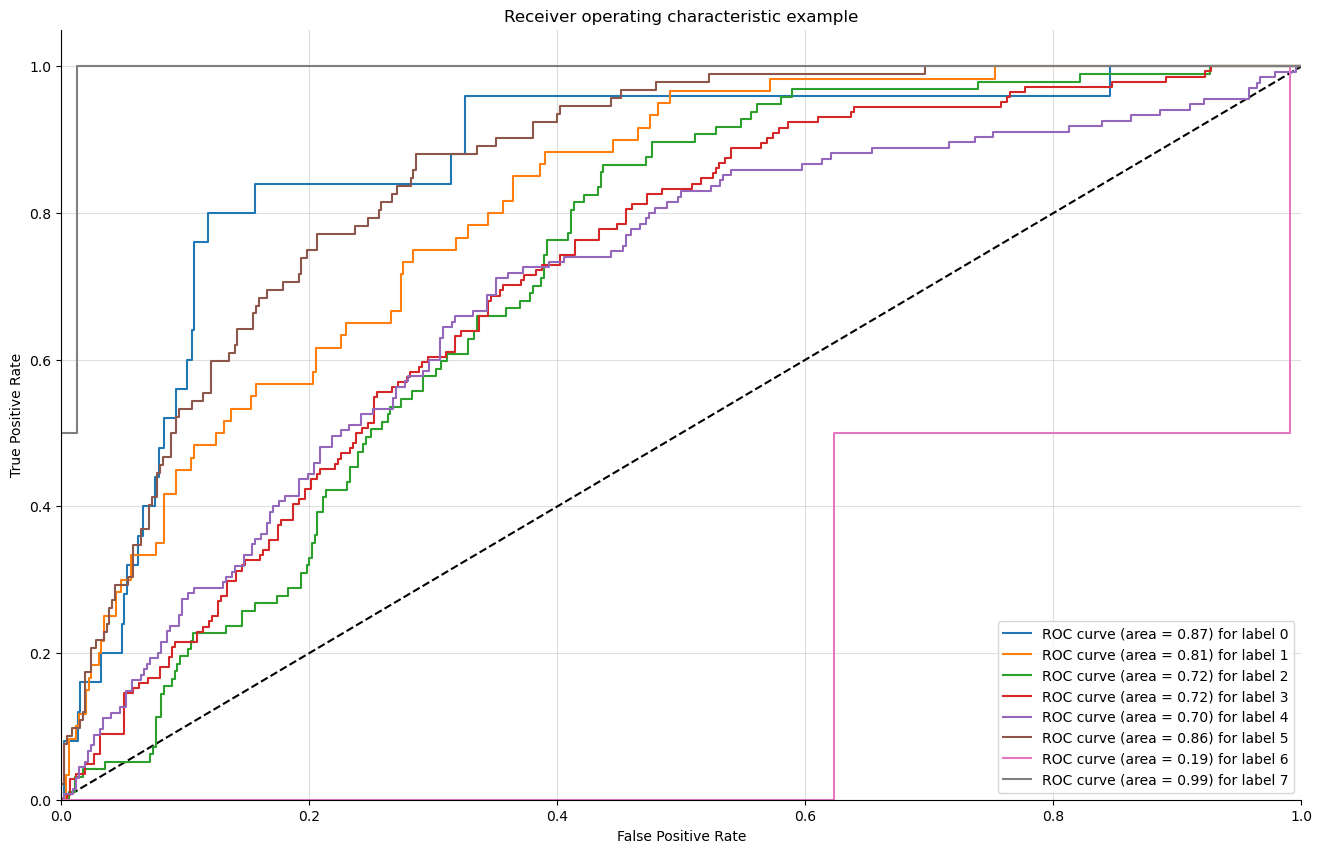

SVC
Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.37      0.25      0.30       240
           2       0.00      0.00      0.00       389
           3       0.33      0.61      0.42       577
           4       0.40      0.54      0.46       538
           5       0.59      0.39      0.47       365
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7

    accuracy                           0.38      2224
   macro avg       0.21      0.22      0.21      2224
weighted avg       0.32      0.38      0.33      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.33      0.22      0.26        60
           2       0.00      0.00      0.00        97
           3       0.35      0.67      0.46       144
           4       0.41      0.54      0.47  

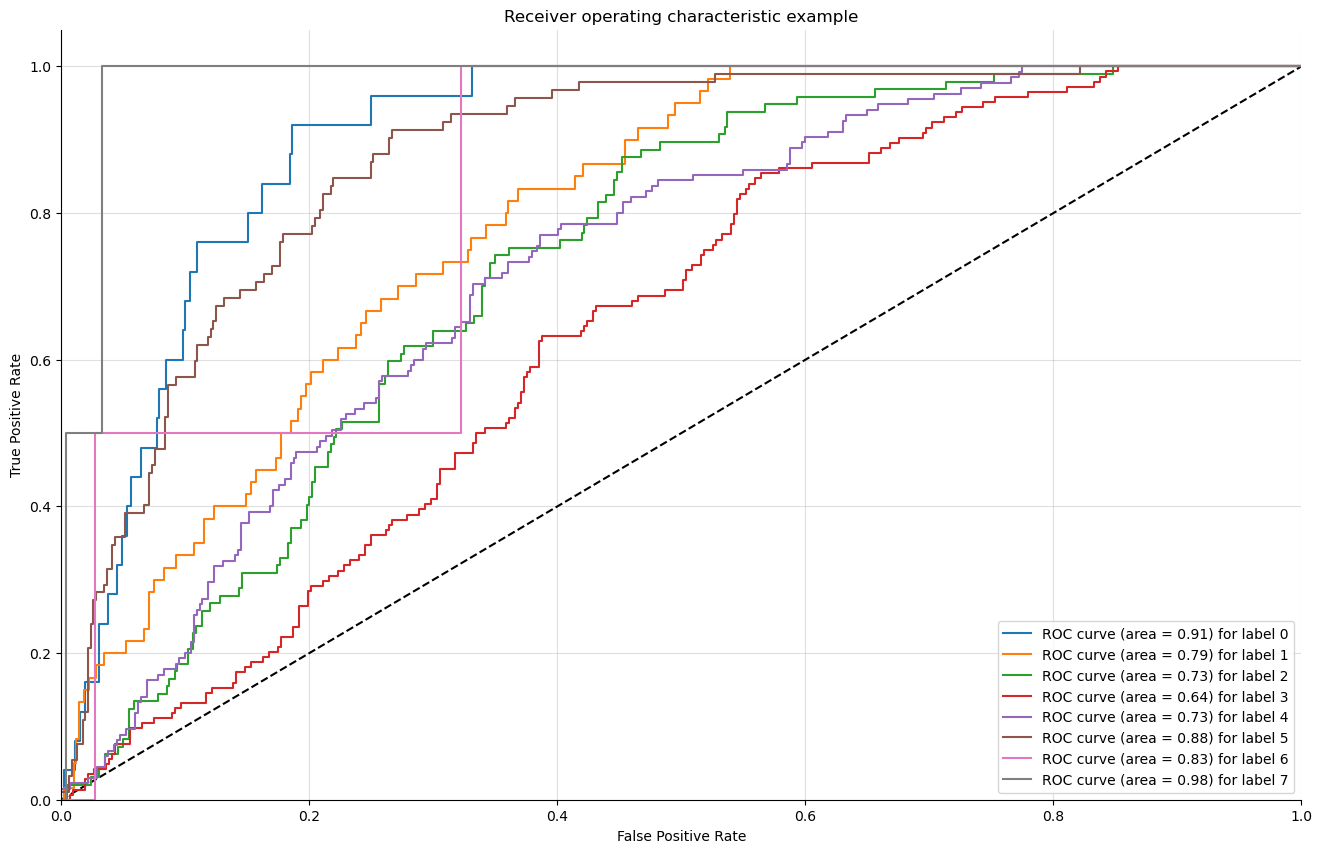

In [43]:
for classifier in classifiers:
    print (classifier.__class__.__name__)
    classifier.fit(X_train, y_train)
    y_train_pred=classifier.predict(X_train)
    print("Y_Train Y_Pred")
    print(classification_report(y_train, y_train_pred))
    y_test_pred = classifier.predict(X_test)
    print("Y_Test Y_Pred")
    print(classification_report(y_test, y_test_pred))
    plot_multiclass_roc(classifier, X_test, y_test, n_classes=8, figsize=(16, 10))

When considering the F1-weighted scores, it is evident that certain models, such as ExtratreesClassifier, LogisticRegression, and LogisticRegressionCV, outperformed others in making predictions on the test set. These models achieved F1-weighted scores of 0.42, 0.41, and 0.42, respectively. Importantly, these models demonstrated good performance without overfitting.

On the other hand, RandomForestClassifier and XGBClassifier models showed signs of overfitting. While they achieved perfect F1-weighted scores of 1 on the training set, their performance on the test set was comparatively lower, with F1-weighted scores of 0.40 and 0.38, respectively.

The discrepancy between the train and test set F1-weighted scores suggests that RandomForestClassifier and XGBClassifier may have learned the training data too well, resulting in limited generalization to new, unseen data. In contrast, models like ExtratreesClassifier, LogisticRegression, and LogisticRegressionCV achieved good F1-weighted scores on both the training and test sets, indicating a more balanced and effective learning process.

Therefore, based on the F1-weighted scores, it is recommended to prioritize models such as ExtratreesClassifier, LogisticRegression, and LogisticRegressionCV for making predictions in this scenario. These models demonstrate better performance without overfitting and are likely to provide more reliable and consistent predictions on unseen data.

## K-fold GridSearchCV Approach (Hyper parameter tuning)

Best parameters for SGDClassifier: {'classifier__alpha': 0.001, 'classifier__loss': 'log', 'classifier__penalty': 'l2'}
Best score for SGDClassifier: 0.38256284288354914

Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.57      0.13      0.21        98
           1       0.39      0.34      0.37       240
           2       0.34      0.21      0.26       389
           3       0.36      0.62      0.45       577
           4       0.45      0.31      0.37       538
           5       0.55      0.57      0.56       365
           6       0.00      0.00      0.00        10
           7       1.00      0.14      0.25         7

    accuracy                           0.41      2224
   macro avg       0.46      0.29      0.31      2224
weighted avg       0.42      0.41      0.39      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.25      0.04      0.07        25
           1       0.31      0.25      0

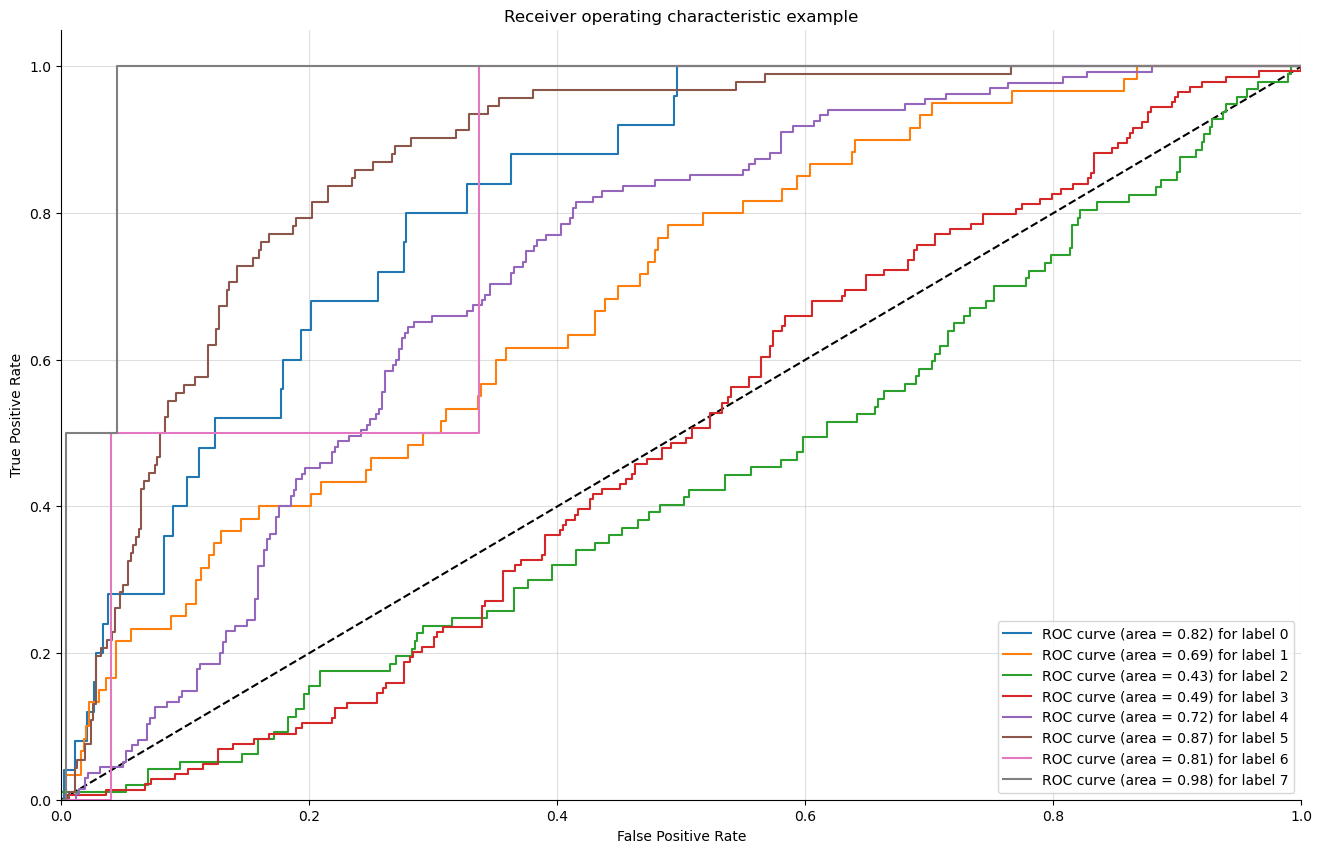

Best parameters for KNeighborsClassifier: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Best score for KNeighborsClassifier: 0.3462391363563785

Y_Train Y_Pred
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       389
           3       1.00      1.00      1.00       577
           4       1.00      1.00      1.00       538
           5       1.00      1.00      1.00       365
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00         7

    accuracy                           1.00      2224
   macro avg       1.00      1.00      1.00      2224
weighted avg       1.00      1.00      1.00      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.25      0.12      0.16        25
           

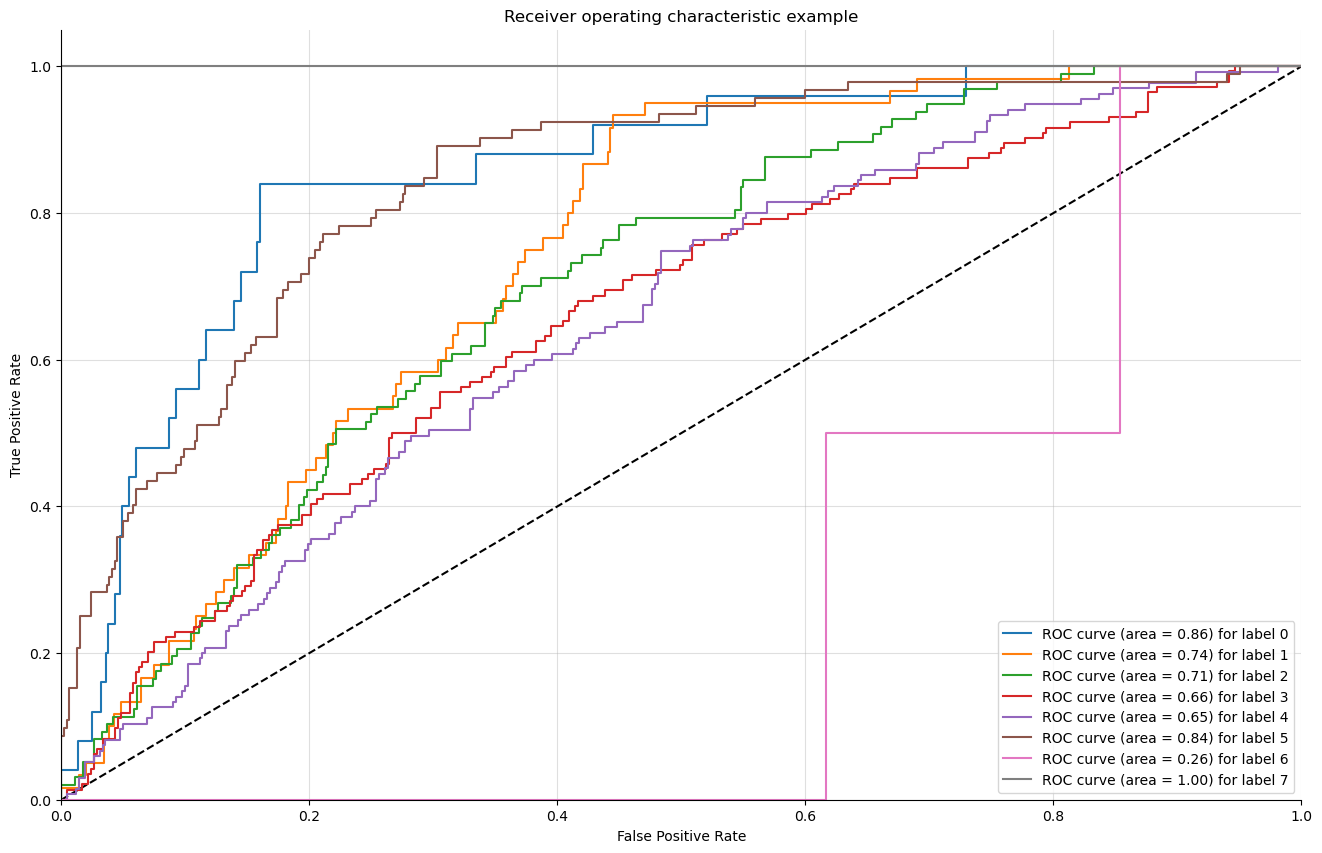

Best parameters for LogisticRegression: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
Best score for LogisticRegression: 0.40684669003971613

Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.57      0.34      0.42        98
           1       0.44      0.38      0.41       240
           2       0.42      0.27      0.33       389
           3       0.40      0.55      0.46       577
           4       0.44      0.46      0.45       538
           5       0.58      0.54      0.56       365
           6       0.67      0.20      0.31        10
           7       0.75      0.43      0.55         7

    accuracy                           0.45      2224
   macro avg       0.53      0.40      0.44      2224
weighted avg       0.46      0.45      0.44      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.08      0.04      0.05        25
           1       0.30      0.27      0.28        60
        

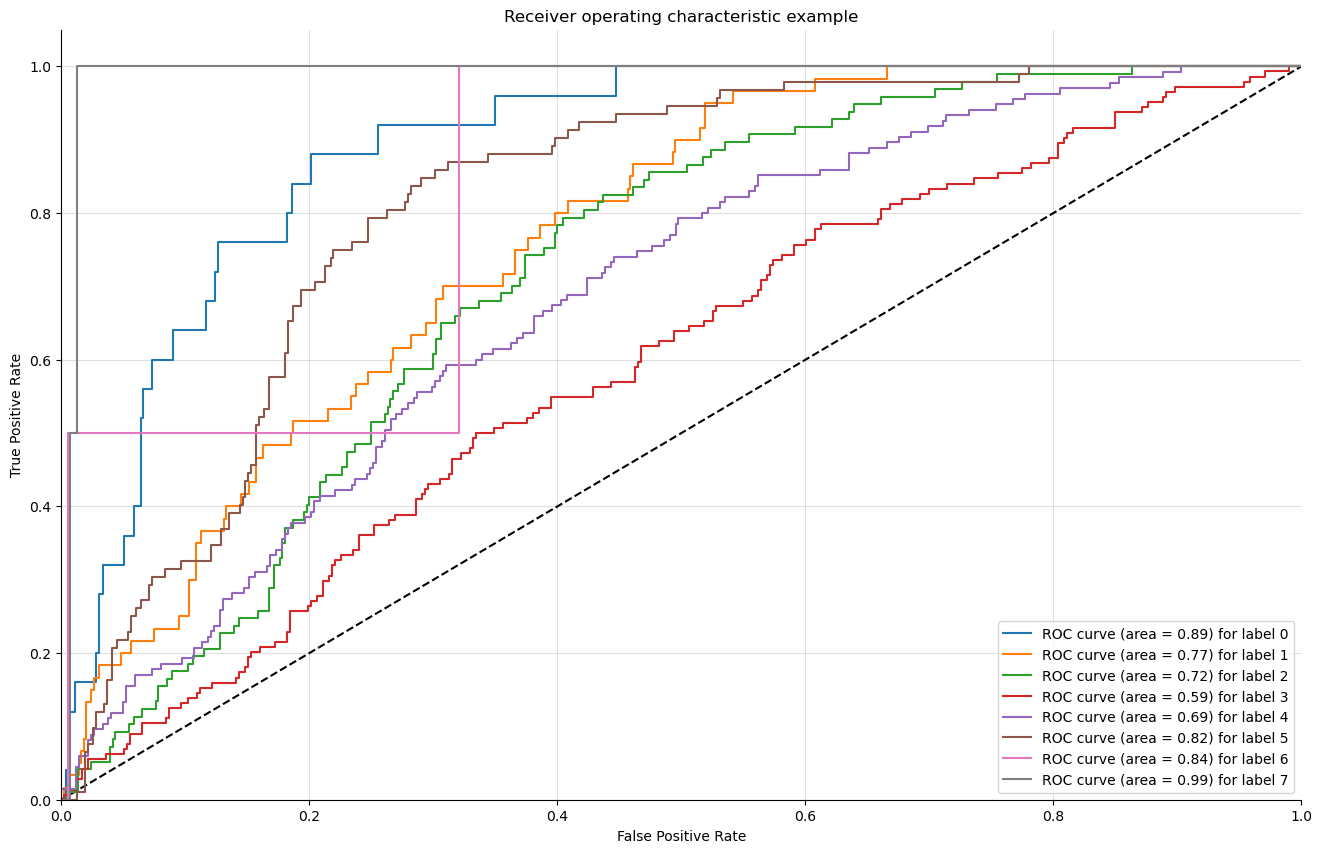

Best parameters for LogisticRegressionCV: {'classifier__Cs': 10, 'classifier__cv': 5}
Best score for LogisticRegressionCV: 0.40509858190274606

Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.54      0.29      0.37        98
           1       0.44      0.38      0.41       240
           2       0.42      0.27      0.33       389
           3       0.39      0.55      0.46       577
           4       0.44      0.46      0.45       538
           5       0.58      0.54      0.56       365
           6       0.00      0.00      0.00        10
           7       1.00      0.14      0.25         7

    accuracy                           0.44      2224
   macro avg       0.48      0.33      0.35      2224
weighted avg       0.45      0.44      0.44      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.10      0.04      0.06        25
           1       0.30      0.28      0.29        60
           2 

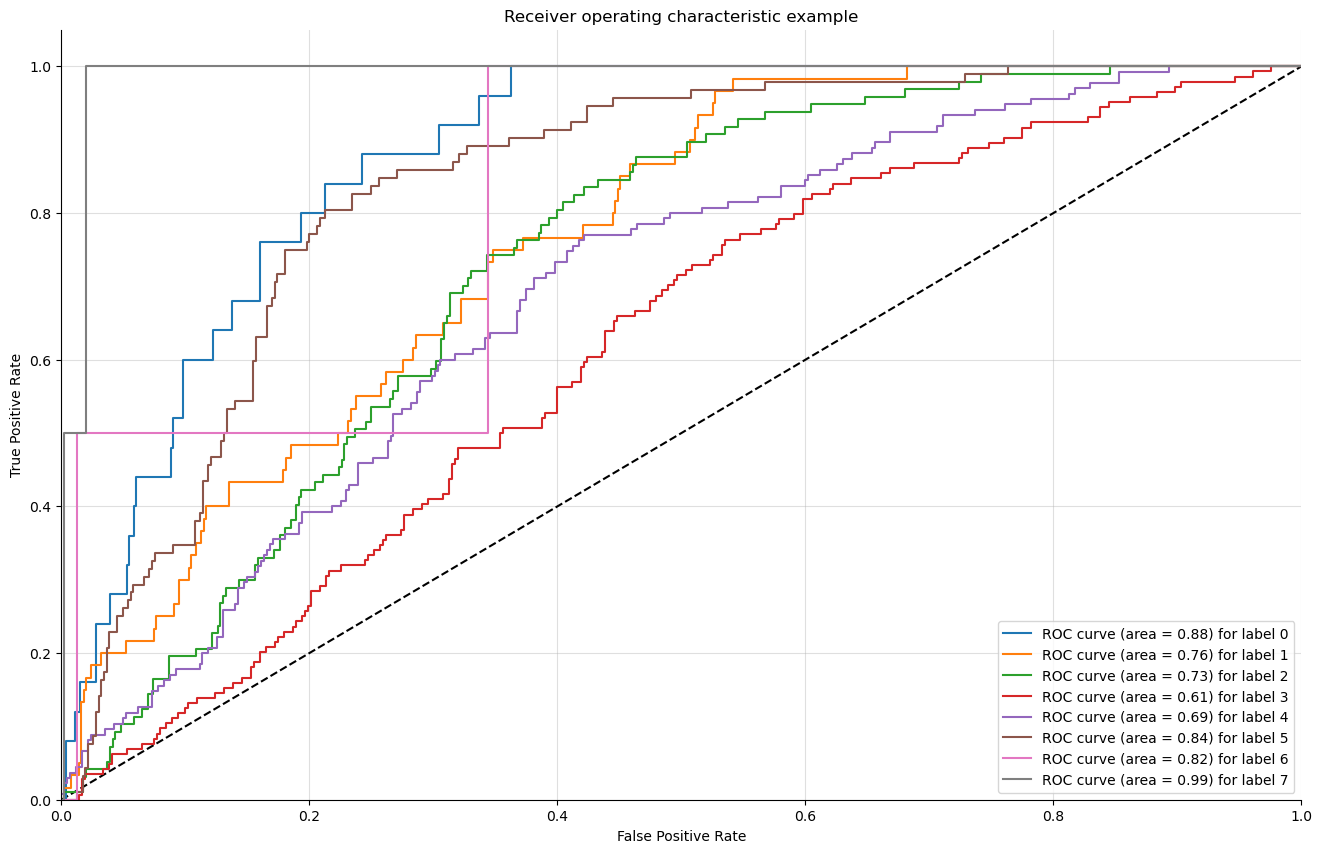

Best parameters for BaggingClassifier: {'classifier__max_features': 0.8, 'classifier__max_samples': 0.8, 'classifier__n_estimators': 100}
Best score for BaggingClassifier: 0.3833583164811751

Y_Train Y_Pred
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       389
           3       1.00      1.00      1.00       577
           4       1.00      1.00      1.00       538
           5       1.00      1.00      1.00       365
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00         7

    accuracy                           1.00      2224
   macro avg       1.00      1.00      1.00      2224
weighted avg       1.00      1.00      1.00      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.17      0.08      0.11        25
           1       

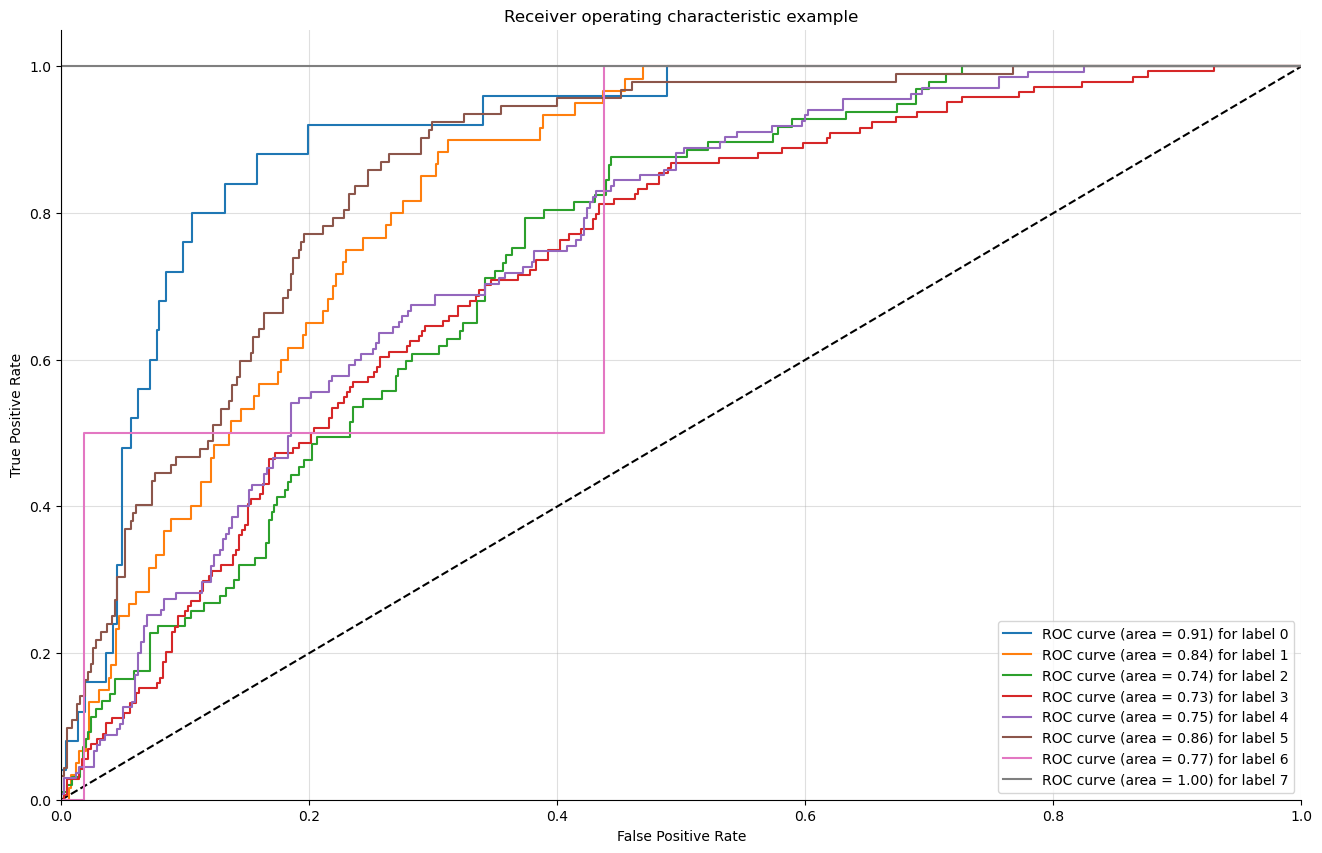

Best parameters for GaussianNB: {}
Best score for GaussianNB: 0.3541276254040521

Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.24      0.59      0.34        98
           1       0.25      0.35      0.29       240
           2       0.31      0.19      0.23       389
           3       0.40      0.33      0.36       577
           4       0.43      0.38      0.41       538
           5       0.50      0.57      0.53       365
           6       0.13      0.50      0.21        10
           7       1.00      1.00      1.00         7

    accuracy                           0.37      2224
   macro avg       0.41      0.49      0.42      2224
weighted avg       0.39      0.37      0.37      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.19      0.44      0.26        25
           1       0.24      0.33      0.28        60
           2       0.26      0.19      0.22        97
           3       0.

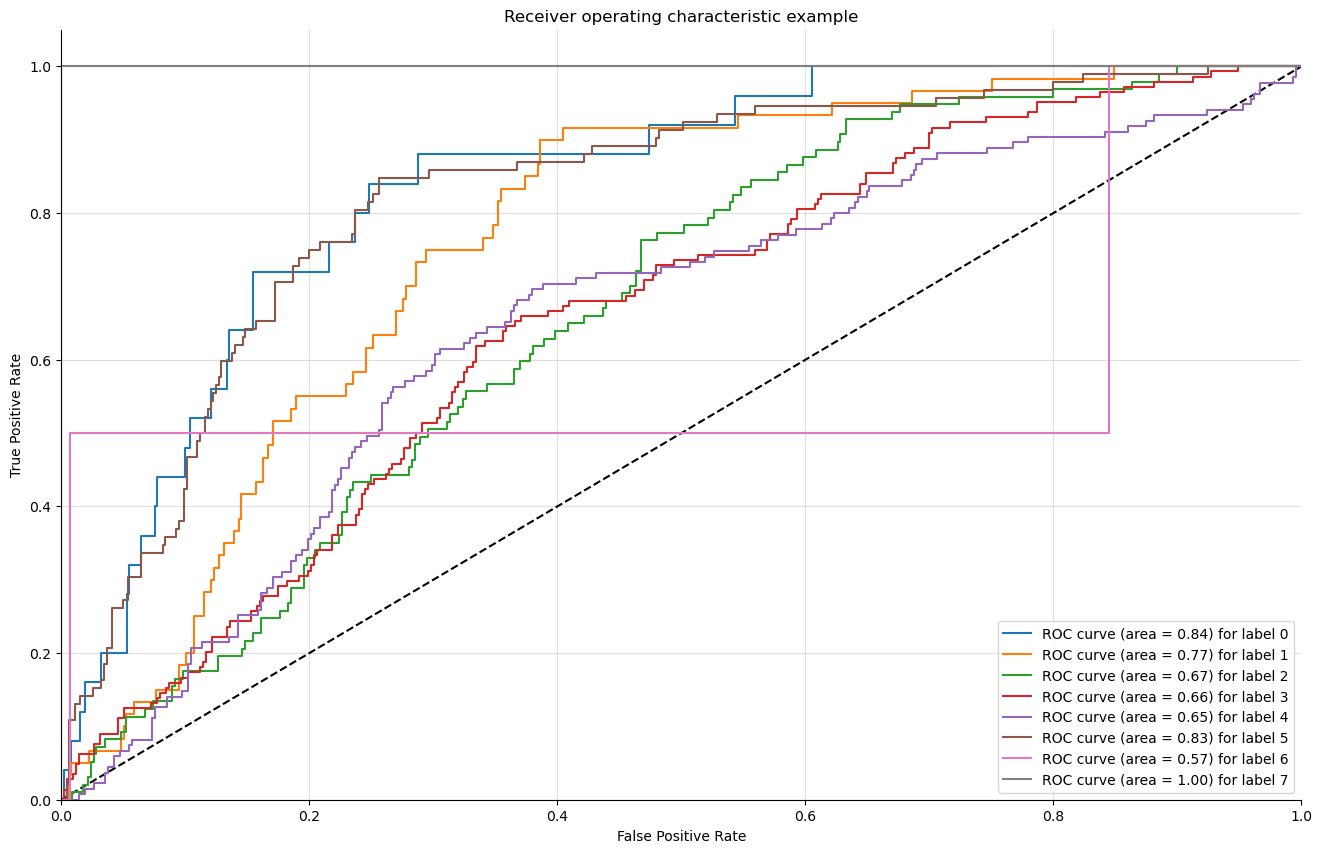

Best parameters for RandomForestClassifier: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best score for RandomForestClassifier: 0.38133704472228114

Y_Train Y_Pred
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        98
           1       0.99      0.93      0.96       240
           2       0.96      0.98      0.97       389
           3       0.95      0.99      0.97       577
           4       0.96      0.97      0.97       538
           5       0.96      0.95      0.96       365
           6       1.00      0.70      0.82        10
           7       1.00      0.86      0.92         7

    accuracy                           0.96      2224
   macro avg       0.98      0.91      0.94      2224
weighted avg       0.97      0.96      0.96      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.40      0.16      0.23        25
           1       0.39      0.28      0.33 

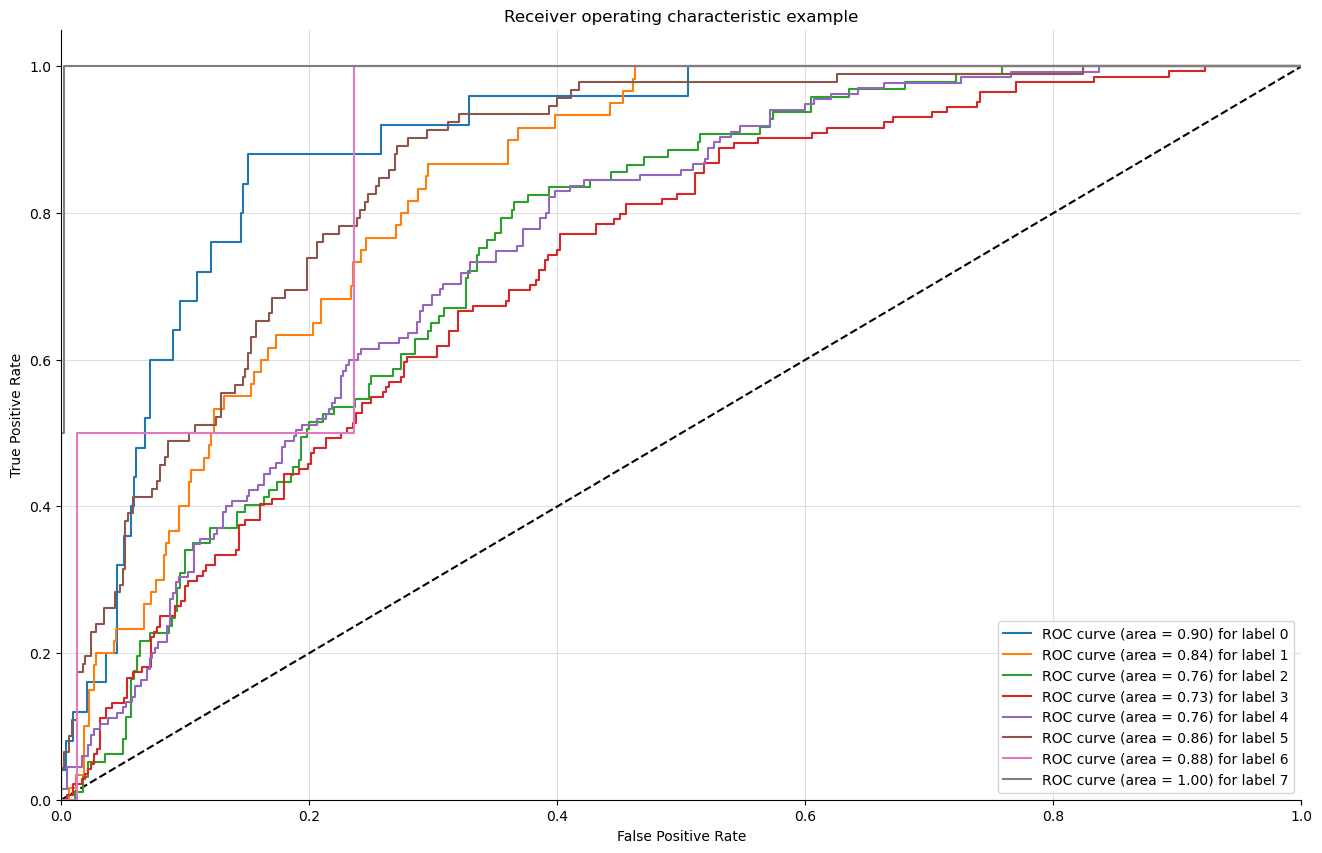

Best parameters for ExtraTreesClassifier: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Best score for ExtraTreesClassifier: 0.38090352892799606

Y_Train Y_Pred
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        98
           1       0.98      0.77      0.86       240
           2       0.93      0.80      0.86       389
           3       0.75      0.95      0.84       577
           4       0.87      0.89      0.88       538
           5       0.95      0.84      0.89       365
           6       1.00      0.60      0.75        10
           7       1.00      0.86      0.92         7

    accuracy                           0.87      2224
   macro avg       0.94      0.82      0.86      2224
weighted avg       0.88      0.87      0.87      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.50      0.12      0.19        25
           1       0.34      0.22      0.27     

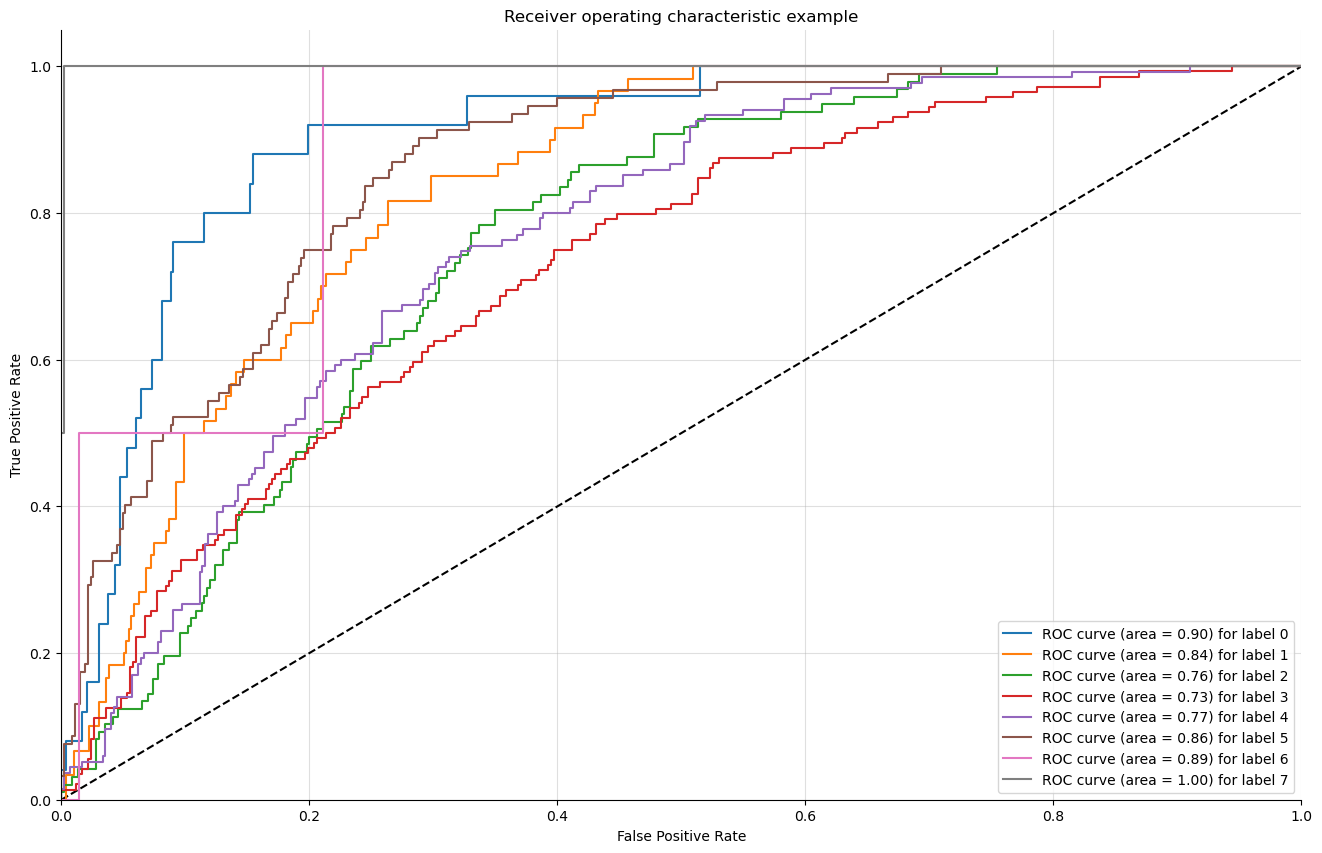

Best parameters for XGBClassifier: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__subsample': 0.5}
Best score for XGBClassifier: 0.3889716270400085

Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.97      0.70      0.82        98
           1       0.90      0.76      0.82       240
           2       0.84      0.77      0.80       389
           3       0.73      0.86      0.79       577
           4       0.81      0.83      0.82       538
           5       0.83      0.82      0.82       365
           6       0.00      0.00      0.00        10
           7       1.00      0.14      0.25         7

    accuracy                           0.81      2224
   macro avg       0.76      0.61      0.64      2224
weighted avg       0.81      0.81      0.80      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.31      0.16      0.21        25
           1       0.36      0.2

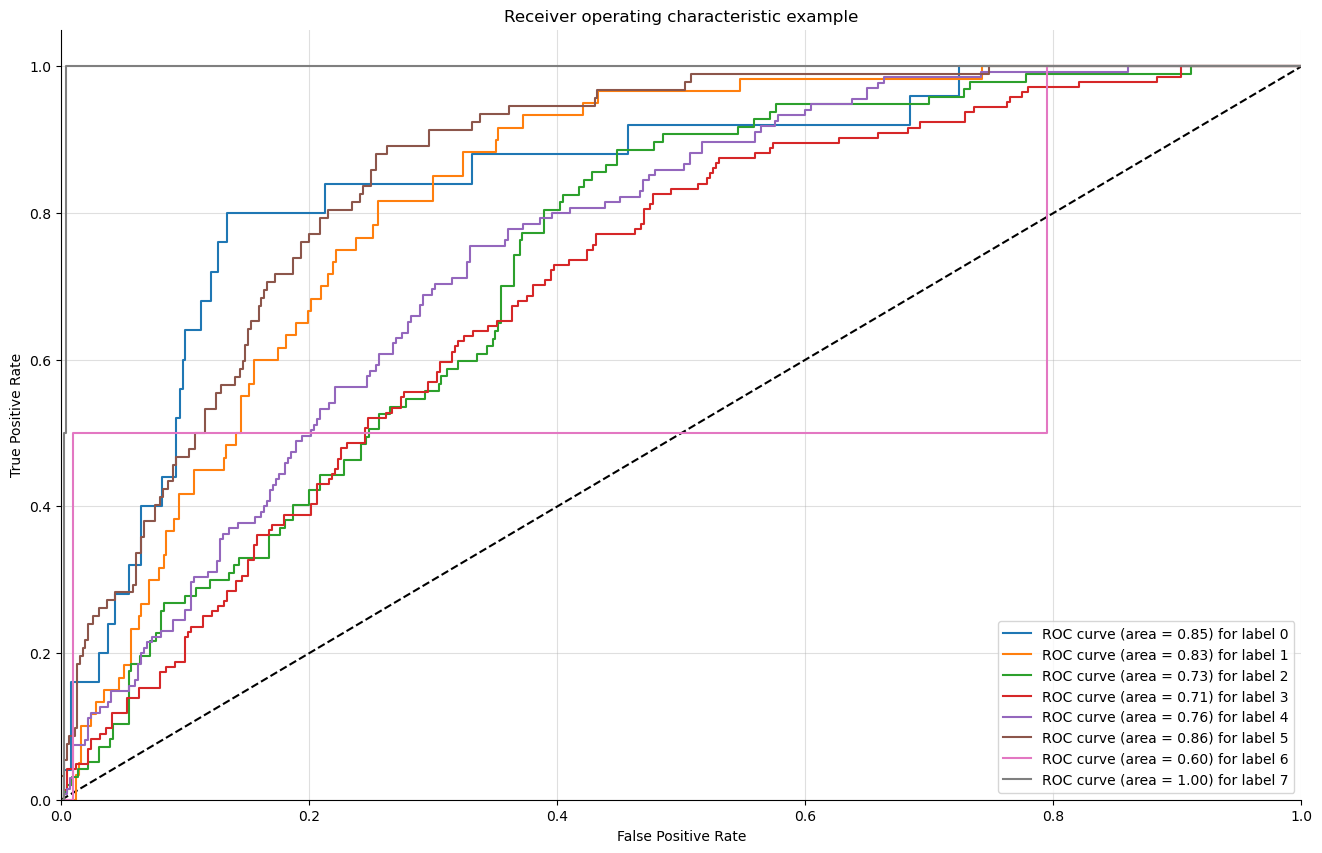

Best parameters for SVC: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best score for SVC: 0.39745246301611037

Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.56      0.31      0.39        98
           1       0.46      0.41      0.44       240
           2       0.38      0.19      0.25       389
           3       0.38      0.56      0.45       577
           4       0.44      0.47      0.45       538
           5       0.58      0.55      0.57       365
           6       0.00      0.00      0.00        10
           7       1.00      0.71      0.83         7

    accuracy                           0.44      2224
   macro avg       0.48      0.40      0.42      2224
weighted avg       0.45      0.44      0.43      2224

Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.27      0.12      0.17        25
           1       0.28      0.25      0.27        60
       

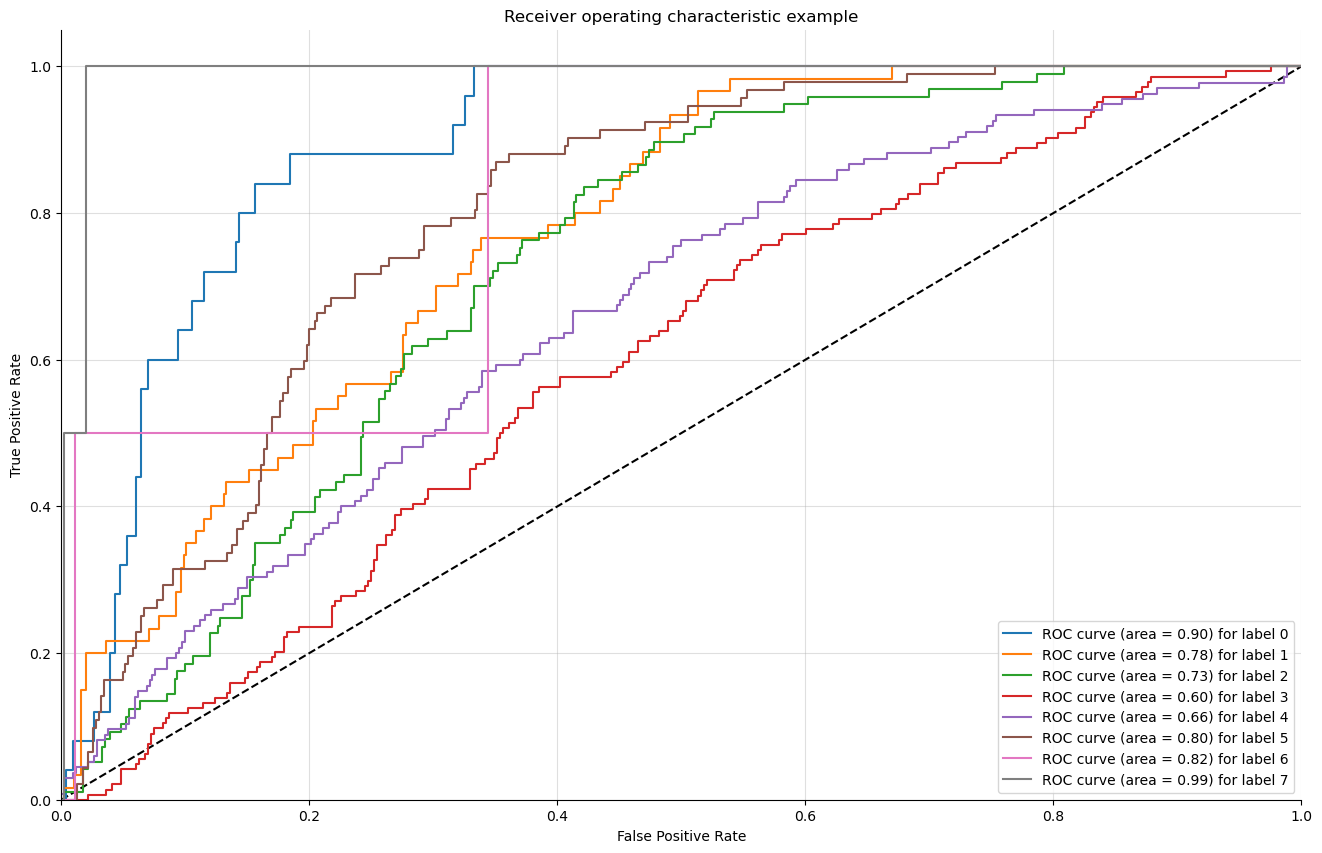

In [44]:
classifiers = [
    SGDClassifier(max_iter=1000, tol=1e-3, random_state=RANDOM_SEED),
    KNeighborsClassifier(),
    LogisticRegression(random_state=RANDOM_SEED),
    LogisticRegressionCV(cv=3, random_state=RANDOM_SEED),
    BaggingClassifier(random_state=RANDOM_SEED),
    GaussianNB(),
    RandomForestClassifier(random_state=RANDOM_SEED),
    ExtraTreesClassifier(random_state=RANDOM_SEED),
    XGBClassifier(random_state=RANDOM_SEED),
    SVC()
]

# Define hyperparameters for each classifier
param_grid = [
    {
        'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__loss': ['log', 'hinge']
    },
    {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    {
        'classifier__Cs': [0.1, 1, 10],
        'classifier__cv': [3, 5]
    },
    {
        'classifier__n_estimators': [10, 50, 100],
        'classifier__max_samples': [0.5, 0.8, 1.0],
        'classifier__max_features': [0.5, 0.8, 1.0]
    },
    {},  # GaussianNB does not have hyperparameters to tune
    {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'classifier__learning_rate': [0.1, 0.01, 0.001],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.5, 0.8, 1.0]
    },
    {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }
]

# Perform hyperparameter tuning for each classifier
for classifier, params in zip(classifiers, param_grid):
    pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', classifier)])
    grid_search = GridSearchCV(pipeline, param_grid=params, scoring='f1_weighted', cv=5)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"Best parameters for {type(classifier).__name__}: {best_params}")
    print(f"Best score for {type(classifier).__name__}: {best_score}\n")
    
    # Fit the model with the best parameters
    best_model = pipeline.set_params(**best_params)
    best_model.fit(X_train, y_train)
    
    y_train_pred = best_model.predict(X_train)
    print("Y_Train Y_Pred")
    print(classification_report(y_train, y_train_pred))
    
    y_test_pred = best_model.predict(X_test)
    print("Y_Test Y_Pred")
    print(classification_report(y_test, y_test_pred))
    
    best_model.fit(X_train, y_train)
    score = kscore_cv(best_model,X_train,y_train)
    print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    plot_multiclass_roc(classifier, X_test, y_test, n_classes=8, figsize=(16, 10))

After performing K-fold GridSearch, significant improvements in overall scores were observed. Both LogisticRegression and LogisticRegressionCV models exhibited a notable increase of 0.1 in their scores, achieving an impressive f1_weighted score of 0.43. This is a noteworthy improvement compared to the previous test set score of 0.42.

## Feature Importance (Logistic Regression)

In [45]:
logreg=LogisticRegression(C=10,solver='lbfgs')
logreg.fit(X_train, y_train)

coefficients = logreg.coef_

avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

fig = px.bar(feature_importance, x='Importance', y='Feature', orientation='h', height=1600)
fig.update_layout(title='Feature Importance', xaxis_title='Importance', yaxis_title='Feature',height=600,
                      width=800)
fig.show()


Inferences regarding their importance in predicting Starcraft Player Performance Rank:

- ActionLatency: ActionLatency appears to be an important feature in predicting player performance rank. Lower action latency indicates faster reaction times and quicker execution of actions, which can be advantageous in gameplay.

- APM (Actions Per Minute): A higher APM is typically associated with better player performance. A higher APM suggests that players are able to perform actions more rapidly and efficiently, demonstrating their ability to execute strategies effectively.

- GapBetweenPACs: The duration between Player Action Commands (PACs) can also impact player performance. A shorter gap between PACs indicates that players are executing actions more frequently and rapidly, which may be advantageous in gameplay.

- TotalHours: The total number of hours played per week can provide insights into a player's dedication and commitment to the game. Players who spend more time practicing and playing Starcraft may have an advantage in terms of experience and skill development.

- ActionsInPAC: The number of actions within each PAC can reflect a player's ability to efficiently execute multiple actions simultaneously. Players who can perform more actions within each PAC may have an advantage in terms of multitasking and strategic decision-making.

- UniqueHotkeys: The count of unique hotkeys used by players can indicate their proficiency in using shortcut keys and efficiently navigating the game interface. Players with a higher count of unique hotkeys may have better control and faster decision-making in the game.

- UniqueUnitsMade: The count of unique units made per timestamp provides insights into a player's army composition, tech tree progression, adaptability, and strategic choices in Starcraft. Players who can produce a diverse range of unique units may exhibit better strategic decision-making and adaptability during gameplay.

- Age: While age alone may not directly correlate with player performance, it can provide insights into the demographic distribution of players. Younger players may have more time and energy to dedicate to the game, while older players may have more experience and strategic thinking skills.

- HoursPerWeek: The distribution of hours played per week can reflect the level of commitment and dedication of players. Players who consistently invest a significant amount of time per week into practicing and playing Starcraft may have a higher chance of achieving better performance ranks.

## Feature Importance w.r.t Class

In [46]:
for class_index in range(8):
    coefficients = logreg.coef_[class_index]  # Access the coefficients for the specific class
    feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    fig = px.bar(feature_importance, x='Importance', y='Feature', orientation='h')
    fig.update_layout(title='Feature Importance for Class {}'.format(class_index+1),
                      xaxis_title='Importance',
                      yaxis_title='Feature',
                      height=600,
                      width=800)
    fig.show()

From above feature importances it looks like GapBetweenPACs being more important for top players, such as Grandmasters and Professionals, can be justified by considering the strategic nature of the game and the skill level of these players. Here's a justification for GapBetweenPACs being more important for top players:

- Strategic Decision-Making: In Starcraft, making strategic decisions and executing them efficiently is crucial for success. Top players, such as Grandmasters and Professionals, are known for their exceptional strategic thinking and decision-making abilities. They carefully plan their actions and execute them with precision. A shorter GapBetweenPACs indicates a more rapid decision-making process, allowing them to adapt and respond quickly to changes in the game.

- APM Optimization: Actions Per Minute (APM) is a key metric in Starcraft that measures the speed at which players execute actions. Top players are often known for their high APM, as they can perform a large number of actions within a short period. A shorter GapBetweenPACs contributes to achieving a higher APM, enabling top players to maintain a fast pace of gameplay and execute more actions effectively.

- Multitasking and Efficiency: Starcraft requires players to multitask and manage multiple aspects of the game simultaneously, such as resource management, unit control, and scouting. Top players excel in multitasking and efficiently allocating their attention and actions across different game areas. A shorter GapBetweenPACs allows them to distribute their actions more evenly and efficiently, maximizing their multitasking capabilities.

- Competitive Advantage: In highly competitive environments like professional Starcraft competitions, even the smallest time advantage can make a significant difference in gameplay outcomes. Top players aim to gain any possible advantage over their opponents. By minimizing the GapBetweenPACs, they can maintain a faster pace of play, catch opponents off guard, and gain a competitive edge during crucial moments in the game.

- Execution Precision: Top players focus on executing their strategies flawlessly. A shorter GapBetweenPACs ensures that they can precisely time their actions, reducing any delays or hesitations between commands. This precision allows them to execute complex maneuvers, micro-control units effectively, and optimize their gameplay strategies.

Overall, the importance of GapBetweenPACs for top players, such as Grandmasters and Professionals, stems from its contribution to rapid decision-making, high APM, multitasking, competitive advantage, and execution precision. These players strive to optimize their gameplay efficiency and gain an edge over their opponents, making GapBetweenPACs a key factor in their success.

## Deep Learning

In [47]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import tensorflow_addons as tfa

In [48]:
X = starcraft_df.drop(["LeagueIndex"], axis=1)
y = starcraft_df["LeagueIndex"]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

In [49]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_cat,
                                                    test_size=0.2,
                                                    stratify=y_cat,
                                                    random_state=42)

In [50]:
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation="relu"))
model.add(BatchNormalization())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(32, activation="relu"))
model.add(Dense(y_cat.shape[1], activation="softmax"))

model.compile(Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4864      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [51]:
model.fit(X_train, y_train, verbose=1, epochs=30, validation_data=(X_test, y_test))


Epoch 1/30
70/70 [==============================] - 2s 9ms/step - loss: 1.8749 - accuracy: 0.3049 - val_loss: 1.8377 - val_accuracy: 0.2424
Epoch 2/30
70/70 [==============================] - 0s 4ms/step - loss: 1.5469 - accuracy: 0.3678 - val_loss: 1.6484 - val_accuracy: 0.2765
Epoch 3/30
70/70 [==============================] - 0s 4ms/step - loss: 1.4620 - accuracy: 0.3853 - val_loss: 1.5439 - val_accuracy: 0.3196
Epoch 4/30
70/70 [==============================] - 0s 4ms/step - loss: 1.4273 - accuracy: 0.3930 - val_loss: 1.4834 - val_accuracy: 0.3501
Epoch 5/30
70/70 [==============================] - 0s 4ms/step - loss: 1.4088 - accuracy: 0.3871 - val_loss: 1.4270 - val_accuracy: 0.3806
Epoch 6/30
70/70 [==============================] - 0s 4ms/step - loss: 1.3978 - accuracy: 0.3979 - val_loss: 1.4199 - val_accuracy: 0.3627
Epoch 7/30
70/70 [==============================] - 0s 4ms/step - loss: 1.3936 - accuracy: 0.3853 - val_loss: 1.4300 - val_accuracy: 0.3429
Epoch 8/30
70/70 [==

In [52]:
y_train_probabilities=model.predict(X_train)
print("Y_Train Y_Pred")
y_train_pred = np.argmax(y_train_probabilities, axis=1)
y_train_class = np.argmax(y_train, axis=1)
print(classification_report(y_train_class, y_train_pred))

y_test_probabilities=model.predict(X_test)
print("Y_Test Y_Pred")
y_test_pred = np.argmax(y_test_probabilities, axis=1)
y_test_class = np.argmax(y_test, axis=1)
print(classification_report(y_test_class, y_test_pred))

70/70 [==============================] - 0s 2ms/step
Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.52      0.26      0.34        98
           1       0.40      0.43      0.42       240
           2       0.38      0.57      0.46       389
           3       0.44      0.50      0.47       577
           4       0.48      0.48      0.48       538
           5       0.69      0.29      0.41       365
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7

    accuracy                           0.45      2224
   macro avg       0.37      0.32      0.32      2224
weighted avg       0.48      0.45      0.44      2224

18/18 [==============================] - 0s 2ms/step
Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.50      0.32      0.39        25
           1       0.35      0.35      0.35        60
           2       0.29      0.38      0.33        

## Improving Deep Learning Model

In [53]:
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Increase the dropout rate for better regularization
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Increase the dropout rate
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Increase the dropout rate
model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(y_cat.shape[1], activation="softmax"))

optimizer = Adam(lr=0.001)
loss = "categorical_crossentropy"
metrics = [tfa.metrics.F1Score(num_classes=y_cat.shape[1], average="weighted"),
           Precision(name="precision", thresholds=0.5),
           Recall(name="recall", thresholds=0.5)]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               4864      
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)              

In [54]:
model.fit(X_train, y_train, verbose=1, epochs=30, validation_data=(X_test, y_test))


Epoch 1/30
70/70 [==============================] - 3s 12ms/step - loss: 2.2600 - f1_score: 0.2230 - precision: 0.3029 - recall: 0.0567 - val_loss: 2.0360 - val_f1_score: 0.1253 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
70/70 [==============================] - 0s 6ms/step - loss: 1.8922 - f1_score: 0.2939 - precision: 0.4005 - recall: 0.0697 - val_loss: 1.7435 - val_f1_score: 0.2426 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
70/70 [==============================] - 0s 5ms/step - loss: 1.7016 - f1_score: 0.3311 - precision: 0.4648 - recall: 0.0832 - val_loss: 1.5960 - val_f1_score: 0.2359 - val_precision: 1.0000 - val_recall: 0.0018
Epoch 4/30
70/70 [==============================] - 0s 6ms/step - loss: 1.6370 - f1_score: 0.3505 - precision: 0.4580 - recall: 0.0809 - val_loss: 1.5502 - val_f1_score: 0.2681 - val_precision: 1.0000 - val_recall: 0.0054
Epoch 5/30
70/70 [==============================] - 0s 5ms/step - loss: 1.5653 - f1_score: 0.33

In [55]:
y_train_probabilities=model.predict(X_train)
print("Y_Train Y_Pred")
y_train_pred = np.argmax(y_train_probabilities, axis=1)
y_train_class = np.argmax(y_train, axis=1)
print(classification_report(y_train_class, y_train_pred))

y_test_probabilities=model.predict(X_test)
print("Y_Test Y_Pred")
y_test_pred = np.argmax(y_test_probabilities, axis=1)
y_test_class = np.argmax(y_test, axis=1)
print(classification_report(y_test_class, y_test_pred))

70/70 [==============================] - 0s 2ms/step
Y_Train Y_Pred
              precision    recall  f1-score   support

           0       0.39      0.32      0.35        98
           1       0.39      0.12      0.19       240
           2       0.37      0.30      0.33       389
           3       0.39      0.57      0.46       577
           4       0.44      0.44      0.44       538
           5       0.54      0.54      0.54       365
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         7

    accuracy                           0.42      2224
   macro avg       0.31      0.29      0.29      2224
weighted avg       0.42      0.42      0.41      2224

18/18 [==============================] - 0s 2ms/step
Y_Test Y_Pred
              precision    recall  f1-score   support

           0       0.36      0.36      0.36        25
           1       0.30      0.12      0.17        60
           2       0.31      0.25      0.28        

# Based on our Analysis for Starcraft Player Performance Rank Prediction we go with Logistic Regression and the most important features for predicting the rank are 
- GAPbetweenPACs, 
- ActionLatency, 
- Action Per Minutes (APM), 
- UniqueHotKeys, 
- TotalHours, 
- HoursPerWeek,
- UniqueUnitsMade

# Hypothetical: after seeing your work, your stakeholders come to you and say that they can collect more data, but want your guidance before starting. How would you advise them based on your EDA and model results?


Based on the analysis for Starcraft Player Performance Rank Prediction, where we used Logistic Regression as the chosen model, and identified important features for predicting the rank, such as GAPbetweenPACs, ActionLatency, Action Per Minutes (APM), UniqueHotKeys, TotalHours, HoursPerWeek, and UniqueUnitsMade, here's how you can advise stakeholders regarding collecting more data:

1. Collecting More Data:
   - Based on our current analysis and model results, it would be beneficial to collect additional data to further improve the accuracy and robustness of the model.
   - Collecting more data will provide a larger and more diverse sample of player performance, leading to a more comprehensive understanding of the factors influencing rank prediction.

2. Focus on Key Features:
   - Given the importance of certain features in the current model, such as GAPbetweenPACs, ActionLatency, APM, UniqueHotKeys, TotalHours, HoursPerWeek, and UniqueUnitsMade, it would be valuable to collect more data specifically related to these features.
   - Ensure that the newly collected data includes information on these key features for each player, allowing for a more accurate assessment of their rank.

3. Additional Feature Considerations:
   - While the identified features have shown significant importance in predicting player rank, it's also important to consider the potential impact of other features in the game environment.
   - Encourage the collection of data related to other relevant features, such as game strategies, team composition, opponent rankings, or in-game events, to gain a more comprehensive understanding of player performance.

4. Diversify Data Sources:
   - Expand the data collection efforts by considering data from different sources, such as different game modes, player demographics, or regions.
   - This will help capture a broader range of player experiences and ensure that the model's predictions generalize well across various player profiles.

5. Maintain Consistency:
   - While collecting additional data, it's crucial to maintain consistency with the existing dataset in terms of data quality, data format, and variable definitions.
   - Ensure that the new data aligns with the same data collection protocols and standards used for the existing dataset, allowing for seamless integration and comparability.

6. Iterative Model Improvement:
   - Emphasize that collecting more data is an iterative process, and it should be followed by periodic model retraining and evaluation.
   - As the dataset expands, regularly retrain the model to incorporate new insights and assess its performance to ensure it remains accurate and reliable.

These approaches will lead to a more robust and effective model for predicting player performance ranks.